## Apply Bayesian Optimization to building hedged option portfolios around a given expectation function described by the user

In [2]:
%matplotlib inline
import matplotlib
import numpy as np

import datetime
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from collections import defaultdict
import itertools

import pyfolio as pf
import empyrical as emp

import scipy
from scipy.stats import norm 

from math import sqrt, exp, log

import statsmodels.api as sm
import itertools
import time

import statsmodels.api as sm

/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


## Import RobinHood API specific modules

In [3]:
import robin_stocks as r

# import local RobinHood API creds so they don't get pushed to github
import rh_creds

In [4]:
!conda info --envs   # confirm we're in the proper anaconda virutal environment

# conda environments:
#
base                     /Users/justinlent/ana32/anaconda3
                         /Users/justinlent/anaconda_2019_10/anaconda3
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/PROD_quant
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/jupy_IDE
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/jupy_IDE_test
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/jupy_IDE_test_2
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/quant
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_BACKUP_03_29_2020
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_bayesopt_0_1_0
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_cur_1
                         /Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_demark
                         /Users/justinlent/ana

In [5]:
!git branch   # confirm we're working in the proper git branch

* master


# START OPTIMIZER CONFIG ######################

#### Login to Robinhood API

In [ ]:
r.login(rh_creds.un, rh_creds.pw)

#### Pull stock price data for the stock we want to build our options portfolio from

In [812]:
SPY = r.stocks.get_historicals("SPY", span='year', bounds='regular')
SPY = pd.DataFrame(SPY)
SPY.tail()

,begins_at,open_price,close_price,high_price,low_price,volume,session,interpolated,symbol
248,2020-04-23T00:00:00Z,280.490000,279.080000,283.940000,278.750000,104709693,reg,False,SPY
249,2020-04-24T00:00:00Z,280.730000,282.970000,283.700000,278.500000,85165953,reg,False,SPY
250,2020-04-27T00:00:00Z,285.120000,287.050000,288.270000,284.620000,77896608,reg,False,SPY
251,2020-04-28T00:00:00Z,291.020000,285.730000,291.400000,285.400000,105269985,reg,False,SPY
252,2020-04-29T00:00:00Z,291.530000,293.210000,294.880000,290.410000,116160802,reg,False,SPY


#### Specify the expiration dates we want to pull options contract prices for, and pull the prices from Robinhood

In [813]:
exp_dates = [ '2020-06-19'
#              , '2020-07-17'
#              , '2020-08-21'
#              , '2020-09-18'
#              , '2020-10-16' 
            ]
opt_dict = {}

for d in exp_dates:
    print('\n\n' + str(d) )
    opt_dict[ d ] = r.find_options_for_list_of_stocks_by_expiration_date(['SPY'], expirationDate=d)
    
print( opt_dict.keys() )



2020-06-19
Found Additional pages.
Loading page 2 ...
Loading page 3 ...
Loading page 4 ...
Loading page 5 ...
Loading page 6 ...
Loading page 7 ...
Loading page 8 ...
Loading page 9 ...
Loading page 10 ...
Loading page 11 ...
Loading page 12 ...
Loading page 13 ...
Loading page 14 ...
Loading page 15 ...
Loading page 16 ...
Loading page 17 ...
Loading page 18 ...
Loading page 19 ...
Loading page 20 ...
Loading page 21 ...
Loading page 22 ...
Loading page 23 ...
Loading page 24 ...
Loading page 25 ...
Loading page 26 ...
Loading page 27 ...
Loading page 28 ...
Loading page 29 ...
Loading page 30 ...
Loading page 31 ...
Loading page 32 ...
Loading page 33 ...
Loading page 34 ...
Loading page 35 ...
Loading page 36 ...
Loading page 37 ...
Loading page 38 ...
Loading page 39 ...
Loading page 40 ...
Loading page 41 ...
Loading page 42 ...
Loading page 43 ...
Loading page 44 ...
Loading page 45 ...
Loading page 46 ...
Loading page 47 ...
Loading page 48 ...
Loading page 49 ...
Loading pag

In [814]:
opt_1st_df = pd.DataFrame(opt_dict['2020-06-19'])

opt_1st_df.tail()

,chain_id,chain_symbol,created_at,expiration_date,id,issue_date,min_ticks,rhs_tradability,state,strike_price,...,delta,gamma,implied_volatility,rho,theta,vega,high_fill_rate_buy_price,high_fill_rate_sell_price,low_fill_rate_buy_price,low_fill_rate_sell_price
445,c277b118-58d9-4060-8dc5-a3b5898955cb,SPY,2018-06-22T02:10:45.881660Z,2020-06-19,afd466f8-989b-429d-bd6e-f28d8e9681a7,2005-01-06,"{'above_tick': '0.01', 'below_tick': '0.01', '...",tradable,active,175.0000,...,0.989270,0.000424,0.623500,0.235058,-0.019648,0.030382,115.130000,114.740000,114.920000,114.950000
446,c277b118-58d9-4060-8dc5-a3b5898955cb,SPY,2018-06-22T02:10:45.881561Z,2020-06-19,4a2eef1d-1c9c-4083-9d16-d3e2bec44508,2005-01-06,"{'above_tick': '0.01', 'below_tick': '0.01', '...",tradable,active,170.0000,...,0.991265,0.000346,0.637723,0.229068,-0.016875,0.025384,120.100000,119.680000,119.870000,119.910000
447,c277b118-58d9-4060-8dc5-a3b5898955cb,SPY,2018-06-22T02:10:45.881461Z,2020-06-19,cefc60d0-bfef-41fd-9280-95d4e60efa69,2005-01-06,"{'above_tick': '0.01', 'below_tick': '0.01', '...",tradable,active,165.0000,...,-0.009348,0.000343,0.683568,-0.004052,-0.018401,0.026938,0.250000,0.240000,0.240000,0.250000
448,c277b118-58d9-4060-8dc5-a3b5898955cb,SPY,2018-06-22T02:10:45.881363Z,2020-06-19,ecd3772c-551c-4bdf-8d56-d8360c4379fe,2005-01-06,"{'above_tick': '0.01', 'below_tick': '0.01', '...",tradable,active,165.0000,...,0.992873,0.000283,0.652778,0.222912,-0.014524,0.021226,125.050000,124.620000,124.820000,124.860000
449,c277b118-58d9-4060-8dc5-a3b5898955cb,SPY,2018-06-22T02:10:45.881263Z,2020-06-19,7b951ff1-6b67-4ccb-b01f-89941cba39dc,2005-01-06,"{'above_tick': '0.01', 'below_tick': '0.01', '...",tradable,active,265.0000,...,-0.244189,0.007548,0.387792,-0.105752,-0.130140,0.336411,6.480000,6.450000,6.460000,6.470000


In [815]:
np.unique(opt_1st_df.previous_close_date)

array(['2020-04-29'], dtype=object)

In [816]:
opt_1st_df.columns

Index(['chain_id', 'chain_symbol', 'created_at', 'expiration_date', 'id',
       'issue_date', 'min_ticks', 'rhs_tradability', 'state', 'strike_price',
       'tradability', 'type', 'updated_at', 'url', 'adjusted_mark_price',
       'ask_price', 'ask_size', 'bid_price', 'bid_size', 'break_even_price',
       'high_price', 'instrument', 'last_trade_price', 'last_trade_size',
       'low_price', 'mark_price', 'open_interest', 'previous_close_date',
       'previous_close_price', 'volume', 'chance_of_profit_long',
       'chance_of_profit_short', 'delta', 'gamma', 'implied_volatility', 'rho',
       'theta', 'vega', 'high_fill_rate_buy_price',
       'high_fill_rate_sell_price', 'low_fill_rate_buy_price',
       'low_fill_rate_sell_price'],
      dtype='object')

## Do some data cleaning and transforming of the raw data from RobinHood

In [817]:
opt_1st_df.loc[:, ['type', 'strike_price', 'delta', 'last_trade_price'
                   , 'ask_price', 'bid_price', 'previous_close_date'] 
              ].dropna()

,type,strike_price,delta,last_trade_price,ask_price,bid_price,previous_close_date
1,put,207.0000,-0.037623,0.970000,0.940000,0.930000,2020-04-29
2,put,206.0000,-0.036407,0.890000,0.910000,0.900000,2020-04-29
3,call,206.0000,0.967035,83.870000,84.560000,84.270000,2020-04-29
5,put,204.0000,-0.033972,0.810000,0.850000,0.840000,2020-04-29
7,put,201.0000,-0.030707,0.780000,0.770000,0.760000,2020-04-29
...,...,...,...,...,...,...,...
443,put,170.0000,-0.010979,0.290000,0.290000,0.280000,2020-04-29
444,put,175.0000,-0.012992,0.330000,0.340000,0.330000,2020-04-29
446,call,170.0000,0.991265,117.070000,120.190000,119.620000,2020-04-29
447,put,165.0000,-0.009348,0.250000,0.250000,0.240000,2020-04-29


In [823]:
opt_1st_df[ opt_1st_df.strike_price == '295.0000' ][['ask_price', 'bid_price','last_trade_price']]

,ask_price,bid_price,last_trade_price
395,9.390000,9.340000,9.400000
396,15.500000,15.480000,15.500000


In [824]:
opt_1st_df_c = opt_1st_df[ opt_1st_df.type == 'call']
opt_1st_df_p = opt_1st_df[ opt_1st_df.type == 'put']
opt_1st_df_p.loc[ :, 'strike_price_split'] =  [ float(s.split('.')[1]) for s in opt_1st_df_p['strike_price'] ]
opt_1st_df_c.loc[ :, 'strike_price_split'] =  [ float(s.split('.')[1]) for s in opt_1st_df_c['strike_price'] ]
opt_1st_df_p = opt_1st_df_p[ opt_1st_df_p.strike_price_split < 0.00001 ]
opt_1st_df_c = opt_1st_df_c[ opt_1st_df_c.strike_price_split < 0.00001 ]
opt_1st_df_p.loc[ :, 'Strike'] =  [ int(s.split('.')[0]) for s in opt_1st_df_p['strike_price'] ]
opt_1st_df_c.loc[ :, 'Strike'] =  [ int(s.split('.')[0]) for s in opt_1st_df_c['strike_price'] ]
opt_1st_df_p = opt_1st_df_p.set_index('Strike')
opt_1st_df_c = opt_1st_df_c.set_index('Strike')

opt_1st = opt_1st_df_c.join(opt_1st_df_p, how='outer', rsuffix='_P', lsuffix='_C')

cols_rename = ['Exp'
               , 'Delta_C','Vega_C', 'Impl_Vol_C', 'BID_C', 'ASK_C'
               , 'Delta_P', 'Vega_P', 'Impl_Vol_P','BID_P', 'ASK_P' 
              ]

numer_cols = ['Delta_C','Vega_C', 'Impl_Vol_C', 'BID_C', 'ASK_C'
               , 'Delta_P', 'Vega_P', 'Impl_Vol_P','BID_P', 'ASK_P' 
              ]

cols_to_keep = ['expiration_date_C'
                ,'delta_C','vega_C', 'implied_volatility_C', 'bid_price_C', 'ask_price_C'
                ,'delta_P','vega_P', 'implied_volatility_P', 'bid_price_P', 'ask_price_P' 
               ]

opt_1st = opt_1st.loc[:, cols_to_keep ]

opt_1st = opt_1st.rename(columns=dict( zip(cols_to_keep, cols_rename) ) )

opt_1st = opt_1st.dropna()

opt_1st

,Exp,Delta_C,Vega_C,Impl_Vol_C,BID_C,ASK_C,Delta_P,Vega_P,Impl_Vol_P,BID_P,ASK_P
Strike,,,,,,,,,,,
5,2020-06-19,0.999963,0.000166,3.265067,284.410000,284.830000,-0.000080,0.000344,3.508578,0.000000,0.010000
15,2020-06-19,0.999970,0.000134,2.218572,274.400000,274.830000,-0.000122,0.000511,2.494298,0.000000,0.010000
20,2020-06-19,0.999983,0.000079,1.904257,269.400000,269.830000,-0.000138,0.000574,2.241623,0.000000,0.010000
30,2020-06-19,0.999927,0.000318,1.766148,259.500000,259.930000,-0.000167,0.000687,1.893113,0.000000,0.010000
60,2020-06-19,0.999802,0.000806,1.287614,229.500000,229.930000,-0.000448,0.001721,1.388398,0.010000,0.020000
...,...,...,...,...,...,...,...,...,...,...,...
420,2020-06-19,0.001948,0.006636,0.340074,0.010000,0.020000,-0.946205,0.117200,0.584102,131.330000,131.750000
425,2020-06-19,0.001050,0.003775,0.329983,0.000000,0.020000,-0.947786,0.114457,0.596870,136.320000,136.740000
430,2020-06-19,0.001024,0.003691,0.339056,0.000000,0.020000,-0.948441,0.113318,0.611882,141.320000,141.740000


In [825]:
for n in numer_cols:
    opt_1st[ n ] =list( map( float, opt_1st[ n ]) )

In [826]:
quotes_curr = opt_1st.copy()

quotes_curr.head()

,Exp,Delta_C,Vega_C,Impl_Vol_C,BID_C,ASK_C,Delta_P,Vega_P,Impl_Vol_P,BID_P,ASK_P
Strike,,,,,,,,,,,
5,2020-06-19,0.999963,0.000166,3.265067,284.41,284.83,-0.000080,0.000344,3.508578,0.00,0.01
15,2020-06-19,0.999970,0.000134,2.218572,274.40,274.83,-0.000122,0.000511,2.494298,0.00,0.01
20,2020-06-19,0.999983,0.000079,1.904257,269.40,269.83,-0.000138,0.000574,2.241623,0.00,0.01
30,2020-06-19,0.999927,0.000318,1.766148,259.50,259.93,-0.000167,0.000687,1.893113,0.00,0.01
60,2020-06-19,0.999802,0.000806,1.287614,229.50,229.93,-0.000448,0.001721,1.388398,0.01,0.02


In [827]:
SPY.tail()

,begins_at,open_price,close_price,high_price,low_price,volume,session,interpolated,symbol
248,2020-04-23T00:00:00Z,280.490000,279.080000,283.940000,278.750000,104709693,reg,False,SPY
249,2020-04-24T00:00:00Z,280.730000,282.970000,283.700000,278.500000,85165953,reg,False,SPY
250,2020-04-27T00:00:00Z,285.120000,287.050000,288.270000,284.620000,77896608,reg,False,SPY
251,2020-04-28T00:00:00Z,291.020000,285.730000,291.400000,285.400000,105269985,reg,False,SPY
252,2020-04-29T00:00:00Z,291.530000,293.210000,294.880000,290.410000,116160802,reg,False,SPY


## Specify some model inputs based on current market - Robinhood API won't reliably pull intraday prices accurately on stocks/indexes for some reason

In [934]:
vix_current = 0.3499
market_current = 289.6

portfolio_notional = 1000000

Rf = 0.0
div = 0.02

# current_date = '2018-5-3'
# date_to_reprice = '2018-6-8'
# exp_date = '2018-6-15'

current_date = '2020-4-30'
date_to_reprice = '2020-6-11'
exp_date = '2020-6-19'

#### Specify additional optimization configuration info related to market conditions you want to optimize across

In [935]:
iv_atm_absolute_min = 0.08
iv_simulated_absolute_min = 0.06

vix_mkt_beta = {}
vix_mkt_beta[7] = (12, 9, 4)
vix_mkt_beta[14] = (9, 6, 14)
#vix_mkt_beta[30] = (4.49, 6, 4, 9, 11.99, 15.99)
vix_mkt_beta[30] = (1, 2, 4.49, 6, 4, 9)

vix_mkt_beta_for_sim = vix_mkt_beta[30]

max_dd_desired = 0.15

#########################################################################
#########################################################################

# END OPTIMIZER CONFIG

In [936]:
##BMARK-START

In [1677]:
calendar_days_ahead_to_reprice = (pd.to_datetime(date_to_reprice) - pd.to_datetime(current_date)).days
mkt_implied_1sigma_move = (vix_current/sqrt(365.25/calendar_days_ahead_to_reprice))
print(calendar_days_ahead_to_reprice, mkt_implied_1sigma_move )

42 0.11865156622808577


### Specify how an Option contract should be modeled for our simulator

In [938]:
class Option(object):

    def __init__(self, c_or_p, strike, initial_imp_vol, exp_date, num_contracts, Rf, div, initial_underlying_px):

        self.c_or_p = c_or_p
        self.strike = strike
        self.initial_imp_vol = initial_imp_vol
        self.exp_date = pd.to_datetime(exp_date)
        self.num_contracts = num_contracts
        self.Rf = Rf
        self.div = div
        self.initial_underlying_px = initial_underlying_px
        
        
class VolatilitySurface(object):
    
    def __init__(self, type='linear', feature_def=None):
        
        pass

### Extract implied volatility from the current price of the option as seen in real-time price

In [939]:
def calc_iv(option_price, call_put, S, K, T, r):
    n = norm.pdf
    N = norm.cdf

    def bs_price(cp_flag,S,K,T,r,v,q=0.0):
        d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
        d2 = d1-v*sqrt(T)
        if cp_flag == 'c':
            price = S*exp(-q*T)*N(d1)-K*exp(-r*T)*N(d2)
        else:
            price = K*exp(-r*T)*N(-d2)-S*exp(-q*T)*N(-d1)
        return price

    def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
        d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
        return S * sqrt(T)*n(d1)
    
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = option_price - price  # our root

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma


### Off the shelf Black-Scholes model for the purposes of this simulation. Reasonable to use given the constraints of this simulation. The real aspect of model accuracy comes from modeling the current vs. future volatility surface 

In [940]:
"""
# The Black Scholes Formula
# c_or_p : 'c' for call option
# K : strike
# T : time to maturity in years
# r : risk-free interest rate
# d : dividend yield
# v : implied volatility
"""

def bsm(c_or_p, S, K, T, r, d, v):
    #print( S, K, r, d, T, v)
    d1 = (log(float(S)/K) + ((r-d)+v*v/2.)*T) / (v*sqrt(T))
    d2 = d1 - v*sqrt(T)
    
    if c_or_p=='c':
        return S*exp(-d*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2) 
    else:
        return K*exp(-r*T)*norm.cdf(-d2) - S*exp(-d*T)*norm.cdf(-d1)
    
def bsm_greeks(c_or_p, S, K, T, r, d, v, approx_days_to_hold=7):
    g = OrderedDict()
    
    T_sqrt = sqrt(T)
    d1 = (log(float(S)/K) + ((r-d)+v*v/2.)*T) / (v*T_sqrt)
    d2 = d1-v*T_sqrt

    if c_or_p=='c':
        g['delta'] = norm.cdf(d1)
        g['rho'] = K * T * exp(-r*T) * norm.cdf(d2) / 100.
    else:
        g['delta'] = -norm.cdf(-d1)
        g['rho'] = -K * T * exp(-r*T) * norm.cdf(-d2) / 100.
        
    g['gamma'] = norm.pdf(d1) / (S*v*T_sqrt)
    g['vega'] = S * T_sqrt * norm.pdf(d1) / 100.
    g['theta'] =  bsm(c_or_p=c_or_p, S=S, K=K, T=T, r=r, d=d, v=v) - bsm(c_or_p=c_or_p, S=S, K=K, T=T-(1./365.25), r=r, d=d, v=v)
    g['theta'] =  g['theta'] * -1.

    g['theta_approx_over_holding_period'] =  bsm(c_or_p=c_or_p, S=S, K=K, T=T, r=r, d=d, v=v) - bsm(c_or_p=c_or_p, S=S, K=K, T=T-(approx_days_to_hold/365.25), r=r, d=d, v=v)
    g['theta_approx_over_holding_period'] =  ( g['theta_approx_over_holding_period'] / approx_days_to_hold ) * -1.

    return g

### A method for building out how the volatility surface of the options we're trading will transition thru time that the portfolio is held

In [941]:
def reprice_iv_with_skew(option, iv_atm_curr, underlying_px_curr, underlying_px_orig, 
                         skew_model_params=None, skew_model='simple', interpolation='linear'):

    if skew_model=='simple':

        if interpolation=='linear':
            if skew_model_params is None:
                skew_model_params = {}
                
                skew_model_params['iv_atm_curr'] = vix_current                          # for SP500 options this can just be the VIX
                skew_model_params['iv_when_skew_flat'] = 0.50                           # assume skew is completely flat if VIX > 40
                skew_model_params['iv_when_skew_steepest'] = 0.12                       # assume skew is completely flat if VIX > 40
                skew_model_params['iv_steepness_maximum'] = 3.0                         # how to scale the ATM IV for skew based on that ATM IV amount
                
                skew_model_params['iv_absolute_min'] = 0.08                             # the absolute minimum value for IV

                skew_model_params['iv_strike_above_spot_scaling_minimum'] = 0.80                      # how to scale the ATM IV for an strikes way above spot
                skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness'] = 1.10     # the % of the strike versus spot when the scaling_minimum is applied for skew

                skew_model_params['iv_strike_below_spot_scaling_maximum'] = 3.0                       # how to scale the ATM IV for a strike way below spot
                skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness'] = 0.70     # the % of the strike versus spot when the scaling_maximum is applied for skew

                #skew_model_params['underlying_px_curr'] = mkt_px_curr
                #skew_model_params['underlying_px_orig'] = mkt_px_curr

            mkt_move_pct = underlying_px_curr / underlying_px_orig - 1.0
            iv_orig = option.initial_imp_vol
            K_vs_mkt = option.strike / underlying_px_curr

            iv_skew_scaling = 1.0
       
            iv_skew_scaling_steepness_factor = None
            
            if K_vs_mkt < 1.0:   # because of put-call parity this can also be used for both ITM Call & OTM Put implied vol
                iv_steepness_range = np.linspace(skew_model_params['iv_when_skew_steepest'], skew_model_params['iv_when_skew_flat'], 100)
                iv_skew_scaling_range = np.linspace(1.0, 1.0/skew_model_params['iv_steepness_maximum'], 100)

                if iv_atm_curr > skew_model_params['iv_when_skew_flat']:
                    iv_skew_scaling_steepness_factor = 1.0/skew_model_params['iv_steepness_maximum']
                else:
                    iv_skew_scaling_steepness_factor = iv_skew_scaling_range[ np.searchsorted(iv_steepness_range, iv_atm_curr) ]

                if K_vs_mkt < skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness']:
                    iv_skew_scaling = skew_model_params['iv_strike_below_spot_scaling_maximum'] * iv_skew_scaling_steepness_factor

                else:
                    K_vs_mkt_range = np.linspace(skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness'], 1.0, 100)
                    iv_skew_scaling_range = np.linspace(skew_model_params['iv_strike_below_spot_scaling_maximum'] * iv_skew_scaling_steepness_factor, 1.0, 100)
                    iv_skew_scaling = iv_skew_scaling_range[ np.searchsorted(K_vs_mkt_range, K_vs_mkt) ]


            if K_vs_mkt > 1.0:   # because of put-call parity this can also be used for OTM Call & ITM Put implied vol
                if K_vs_mkt > skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness']:
                    iv_skew_scaling = skew_model_params['iv_strike_above_spot_scaling_minimum']
                else:                            
                    K_vs_mkt_range = np.linspace(1.0, skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness'], 100)
                    iv_skew_scaling_range = np.linspace(1.0, skew_model_params['iv_strike_above_spot_scaling_minimum'], 100)
                    iv_skew_scaling = iv_skew_scaling_range[ np.searchsorted(K_vs_mkt_range, K_vs_mkt) ]

    
    repriced_iv = iv_skew_scaling * iv_atm_curr 
    
#    print(option.c_or_p, "iv_atm:", iv_atm_curr, "repriced_iv:", repriced_iv, "mkt_move_pct:", mkt_move_pct, "K:", option.strike, "Mkt:", underlying_px_curr, "K_vs_mkt:", K_vs_mkt, "updated skew scaling:", iv_skew_scaling, '\n')
    
    return repriced_iv


In [942]:
def approximate_term_struct_range_from_iv(iv_atm_curr, ts_range_step_width=0.05, ts_range_amount_from_mid=0.15, term_struct_model_params=None, term_struct_model='simple', interpolation='linear'):

    if skew_model=='simple':

        if interpolation=='linear':
            if term_struct_model_params is None:
                term_struct_model_params = {}
                
                skew_model_params['iv_atm_curr'] = vix_current                          # for SP500 options this can just be the VIX
                skew_model_params['iv_when_ts_flat'] =  0.12                            # flat means when ts scale is 1.0                          
                skew_model_params['iv_when_ts_most_inverted'] = 0.09                       
                skew_model_params['iv_when_ts_steepest'] = 0.50                       
                skew_model_params['scale_ts_minimum'] = 0.5                            # the absolute most scaled DOWN imp vol can be. e.g. if imp vol is 20% and scale_ts_minimum=0.5 would return 10% after the scaling
                skew_model_params['scale_ts_maximum'] = 1.33                           # the absolute most scaled UP imp vol can be. e.g. if imp vol is 20% and scale_ts_maximum=1.33 would return 26.6% after the scaling
                
                skew_model_params['iv_absolute_min'] = 0.08                            # the absolute minimum value for IV after applying the term structure approximation

    range_min =  skew_model_params['scale_ts_minimum']
    range_max =  skew_model_params['scale_ts_maximum']
    range_mid = (range_min + range_max) / 2.
    
    return list( np.arange( range_mid-ts_range_amount_from_mid, range_mid+ts_range_amount_from_mid, ts_range_step_width) )


## Aggregate all of the option portfolio greeks calculations across any arbitrary number of options held in our portfolio

In [943]:
def calc_portfolio_greeks(port, calc_initial_greeks=False, current_date=None, current_mkt_price=None):
    
    individual_port_greeks = {}
    portfolio_level_greeks = {}
    
    for option in port.keys():
        
        if calc_initial_greeks:
            days_to_exp_at_repricing = ( port[option].exp_date - pd.to_datetime(current_date) ).days
            individual_port_greeks[option] = bsm_greeks(c_or_p=port[option].c_or_p, S=port[option].initial_underlying_px, K=port[option].strike, T=days_to_exp_at_repricing/365.25, r=port[option].Rf, d=port[option].div, v=port[option].initial_imp_vol, approx_days_to_hold=30)
            individual_port_greeks[option]['num_contracts'] = port[option].num_contracts
            individual_port_greeks[option]['c_or_p'] = port[option].c_or_p
            individual_port_greeks[option]['delta_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['delta'] * 100.
            individual_port_greeks[option]['vega_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['vega'] * 100.
            individual_port_greeks[option]['theta_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['theta'] * 100.
            individual_port_greeks[option]['theta_hold_period_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['theta_approx_over_holding_period'] * 100.
            individual_port_greeks[option]['gamma_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['gamma'] * 100.
            individual_port_greeks[option]['gamma_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['gamma'] * 100.
            
            
    ind_port_greeks_df = pd.DataFrame(individual_port_greeks).T        
    
    portfolio_level_greeks['delta'] = ind_port_greeks_df.delta_pos.sum()
    portfolio_level_greeks['gamma'] = ind_port_greeks_df.gamma_pos.sum()
    portfolio_level_greeks['theta'] = ind_port_greeks_df.theta_pos.sum()
    portfolio_level_greeks['theta_holding_period_30d_daily_avg'] = ind_port_greeks_df.theta_hold_period_pos.sum()
    portfolio_level_greeks['vega'] = ind_port_greeks_df.vega_pos.sum()
    
    portfolio_level_greeks['delta_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].delta_pos.sum()
    portfolio_level_greeks['delta_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].delta_pos.sum()
    
    portfolio_level_greeks['vega_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].vega_pos.sum()
    portfolio_level_greeks['vega_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].vega_pos.sum()
    
    portfolio_level_greeks['theta_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].theta_pos.sum()
    portfolio_level_greeks['theta_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].theta_pos.sum()

    portfolio_level_greeks['gamma_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].gamma_pos.sum()
    portfolio_level_greeks['gamma_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].gamma_pos.sum()

    
    return { 'individual_port_greeks': individual_port_greeks, 
             'portfolio_level_greeks': portfolio_level_greeks }
    

### Given a strike price you would like to trade, find the nearest strike price available to trade in the current market

In [944]:
def get_nearest_strike_option(option_chain_df, strike, type='closest'):
    orig_strike_rounded = int(np.round(strike))
    #print("entry:", orig_strike_rounded)
    found = False
    
    count = 0
    step = 1
    
    strike_rounded = orig_strike_rounded
    while not found:
        if count > 1000:
            return np.nan
        
        try:
            option = option_chain_df.loc[strike_rounded]
            found = True
            
        except:
            count = count + 1
            if (count % 2) > 0:
                strike_rounded = orig_strike_rounded + step
            else:
                strike_rounded = orig_strike_rounded - step
                step = step + 1
                
            #print("entry:", strike_rounded, "count:", count, "step:", step)
            
            
            
    return option
                
                
    

In [945]:
get_nearest_strike_option(quotes_curr, strike=294.2)

Exp           2020-06-19
Delta_C         0.464264
Vega_C          0.426055
Impl_Vol_C      0.277593
BID_C               9.93
ASK_C               9.98
Delta_P        -0.530683
Vega_P          0.426506
Impl_Vol_P      0.296841
BID_P              14.99
ASK_P              15.02
Name: 294, dtype: object

## Generate all of the trades you should make in the current market from the optimized strategy you discovered

In [946]:
def get_strategy_trades(strat_params, opt_results, exp_date, Rf, div, calendar_days_ahead_to_reprice, 
                        normalize_to_max_dd=0.10, 
                        portfolio_notional=100000, underlying_spot=999.99):
    
    max_dd_scale = abs( normalize_to_max_dd / opt_results.port_pct_pnl.min() )
    print('Max DD scaled to ', normalize_to_max_dd, ' scaling factor for exp_factor parameter = ', max_dd_scale, '\n')

    strat_params_dict = OrderedDict()

    strat_params_dict['short_put_1_notional'] = strat_params[0]
    strat_params_dict['long_put_1_notional'] = strat_params[1]
    strat_params_dict['long_put_2_notional'] = strat_params[2]
    strat_params_dict['long_put_3_notional'] = strat_params[3]

    strat_params_dict['short_put_1_mness'] = strat_params[4]
    strat_params_dict['long_put_1_mness'] =  strat_params[5]
    strat_params_dict['long_put_2_mness'] = strat_params[6]
    strat_params_dict['long_put_3_mness'] = strat_params[7]

    strat_params_dict['input_short_underlying_hedge_ratio'] = strat_params[8]
    strat_params_dict['input_long_call_1_hedge_factor'] = strat_params[9]
    strat_params_dict['input_exposure_factor'] = strat_params[10]
    #print('input_exposure_factor', strat_params_dict['input_exposure_factor'])
    strat_params_dict['input_exposure_factor'] = strat_params_dict['input_exposure_factor'] * max_dd_scale
    #print('input_exposure_factor', strat_params_dict['input_exposure_factor'])
        
    #print(strat_params_dict)
    
    portfolio_equity = portfolio_notional
    market_current = underlying_spot
    contracts_100pct_notional = portfolio_equity / (market_current * 100.)
    #print('contracts_100pct_notional', contracts_100pct_notional)

    exposure_factor = strat_params_dict['input_exposure_factor']
    short_underlying_hedge_ratio = strat_params_dict['input_short_underlying_hedge_ratio']
    call_1_hedge_factor = strat_params_dict['input_long_call_1_hedge_factor']

    num_contracts_short_put_1 = int( contracts_100pct_notional * exposure_factor )
    #print('num_contracts_short_put_1', num_contracts_short_put_1, exposure_factor)

    port = OrderedDict()

    temp_strike_theo = market_current * strat_params_dict['short_put_1_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['short_put_1_notional'] * num_contracts_short_put_1 )
    port['short_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_1_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['long_put_1_notional'] * num_contracts_short_put_1 )
    port['long_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_2_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['long_put_2_notional'] * num_contracts_short_put_1 )
    port['long_put_2'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * strat_params_dict['long_put_3_mness']
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( strat_params_dict['long_put_3_notional'] * num_contracts_short_put_1 ) 
    port['long_put_3'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')


    portfolio_greeks_info_puts_only = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    #print(portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts'], market_current)
    portfolio_greeks_info_puts_only_delta = portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta']


    short_underlying_hedge_delta = short_underlying_hedge_ratio * portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts']
    port_equity_pos = market_current * short_underlying_hedge_delta
    
    temp_strike_theo = 0.00
    num_contracts_long_call_1 = 0
    if short_underlying_hedge_delta <= 0:
        num_contracts_long_call_1 = int( ((port_equity_pos / market_current) / 100.) * (call_1_hedge_factor * -1.) ) + int(1)
        temp_strike_theo = market_current * 1.005
    else:
        #num_contracts_long_call_1 = int( ((port_equity_pos / market_current) / 100.) * (call_1_hedge_factor * 1.) )
        num_contracts_long_call_1 = int( (short_underlying_hedge_delta / 100.) + 1. )  # buy protective puts
        temp_strike_theo = market_current * 0.85
    

    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = num_contracts_long_call_1
    
    if short_underlying_hedge_delta <= 0:
        port['long_call_1'] = Option(c_or_p='c', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_C, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
        #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')
    else:
        port['long_call_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)

    portfolio_greeks_info = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    ind_port_greeks = pd.DataFrame(portfolio_greeks_info['individual_port_greeks']).T

    portfolio_greeks_info['portfolio_level_greeks']['delta_options'] = portfolio_greeks_info['portfolio_level_greeks']['delta']
    portfolio_greeks_info['portfolio_level_greeks']['delta_options_puts_only'] = portfolio_greeks_info_puts_only_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta_underlying'] = short_underlying_hedge_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options'] + portfolio_greeks_info['portfolio_level_greeks']['delta_underlying']


    ##################################################################################

#     calendar_days_ahead_to_reprice = (pd.to_datetime(date_to_reprice) - pd.to_datetime(current_date)).days

    port_initial_prices = {}
    for option in port.keys():
        days_to_exp_init = ( port[option].exp_date - pd.to_datetime(current_date) ).days
        port_initial_prices[option] = bsm(c_or_p=port[option].c_or_p, S=market_current, K=port[option].strike, T=days_to_exp_init/365.25, r=Rf, d=div, v=port[option].initial_imp_vol)

             
    return { 'portfolio': port, 
             'greeks' : portfolio_greeks_info, 
             'initial_prices' : port_initial_prices,
             'strat_params' : strat_params_dict
           }



def gen_trades_from_bo_result(bo_strat, strat_params_explore, strat_to_get=0
                              , num_explore_results=10
                              , num_results_total=30
                             ):
    
    count = 0
    count_explore = 0
    count_best_bo = 0

    if strat_to_get >= num_results_total:
        print("ERROR: Please enter a valid index from the optimization subplots. Valid values are 0 to", str(num_results_total-1) )
        return None, None
        
    num_explore_combos = None
    if num_explore_results is None:
        num_explore_combos = len( strat_params_explore[ list(strat_params_explore.keys())[0] ] )
    else:
        num_explore_combos = num_explore_results

    top_opt_results_idx = get_top_opt_results(bo_strat, top_n=num_results_total)

    if strat_to_get == 0:
        temp_opt_res, strat_params = run_bo_result(bo_strat)
    else:
        if strat_to_get <= num_explore_combos:
            temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='init_trial', trial_num=strat_to_get - 1 )                

        else:
            temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='bo_trial', trial_num=top_opt_results_idx[ strat_to_get - num_explore_combos - 1] )

    # return temp_opt_res, strat_params
    
    return get_strategy_trades(strat_params=strat_params, opt_results=temp_opt_res, 
                               exp_date=exp_date, Rf=Rf, div=div, 
                               calendar_days_ahead_to_reprice=calendar_days_ahead_to_reprice, 
                               normalize_to_max_dd=max_dd_desired, portfolio_notional=portfolio_notional, 
                               underlying_spot=market_current)


# Build portfolio from a given set of inputs. This is what the optimizer will iterate on to find the best strategies

In [1029]:
def single_opt_run(opt_run_inputs):
    #print('single run')
    import numpy as np
    import pandas as pd
    from collections import OrderedDict
    from math import sqrt, log, exp
    import scipy
    from scipy.stats import norm 
    
    
    class Option(object):
        def __init__(self, c_or_p, strike, initial_imp_vol, exp_date, num_contracts, Rf, div, initial_underlying_px):

            self.c_or_p = c_or_p
            self.strike = strike
            self.initial_imp_vol = initial_imp_vol
            self.exp_date = pd.to_datetime(exp_date)
            self.num_contracts = num_contracts
            self.Rf = Rf
            self.div = div
            self.initial_underlying_px = initial_underlying_px
      
    def bsm(c_or_p, S, K, T, r, d, v):
        d1 = (log(float(S)/K) + ((r-d)+v*v/2.)*T) / (v*sqrt(T))
        d2 = d1 - v*sqrt(T)

        if c_or_p=='c':
            return S*exp(-d*T)*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2) 
        else:
            return K*exp(-r*T)*norm.cdf(-d2) - S*exp(-d*T)*norm.cdf(-d1)
    
    def bsm_greeks(c_or_p, S, K, T, r, d, v, approx_days_to_hold=7):
        g = OrderedDict()

        T_sqrt = sqrt(T)
        d1 = (log(float(S)/K) + ((r-d)+v*v/2.)*T) / (v*T_sqrt)
        d2 = d1-v*T_sqrt

        if c_or_p=='c':
            g['delta'] = norm.cdf(d1)
            g['rho'] = K * T * exp(-r*T) * norm.cdf(d2) / 100.
        else:
            g['delta'] = -norm.cdf(-d1)
            g['rho'] = -K * T * exp(-r*T) * norm.cdf(-d2) / 100.

        g['gamma'] = norm.pdf(d1) / (S*v*T_sqrt)
        g['vega'] = S * T_sqrt * norm.pdf(d1) / 100.
        g['theta'] =  bsm(c_or_p=c_or_p, S=S, K=K, T=T, r=r, d=d, v=v) - bsm(c_or_p=c_or_p, S=S, K=K, T=T-(1./365.25), r=r, d=d, v=v)
        g['theta'] =  g['theta'] * -1.

        g['theta_approx_over_holding_period'] =  bsm(c_or_p=c_or_p, S=S, K=K, T=T, r=r, d=d, v=v) - bsm(c_or_p=c_or_p, S=S, K=K, T=T-(approx_days_to_hold/365.25), r=r, d=d, v=v)
        g['theta_approx_over_holding_period'] =  ( g['theta_approx_over_holding_period'] / approx_days_to_hold ) * -1.

        return g
    
    def calc_portfolio_greeks(port, calc_initial_greeks=False, current_date=None, current_mkt_price=None):    
        individual_port_greeks = {}
        portfolio_level_greeks = {}

        for option in port.keys():

            if calc_initial_greeks:
                days_to_exp_at_repricing = ( port[option].exp_date - pd.to_datetime(current_date) ).days
                individual_port_greeks[option] = bsm_greeks(c_or_p=port[option].c_or_p, S=port[option].initial_underlying_px, K=port[option].strike, T=days_to_exp_at_repricing/365.25, r=port[option].Rf, d=port[option].div, v=port[option].initial_imp_vol, approx_days_to_hold=30)
                individual_port_greeks[option]['num_contracts'] = port[option].num_contracts
                individual_port_greeks[option]['c_or_p'] = port[option].c_or_p
                individual_port_greeks[option]['delta_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['delta'] * 100.
                individual_port_greeks[option]['vega_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['vega'] * 100.
                individual_port_greeks[option]['theta_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['theta'] * 100.
                individual_port_greeks[option]['theta_hold_period_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['theta_approx_over_holding_period'] * 100.
                individual_port_greeks[option]['gamma_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['gamma'] * 100.
                individual_port_greeks[option]['gamma_pos'] = individual_port_greeks[option]['num_contracts'] * individual_port_greeks[option]['gamma'] * 100.


        ind_port_greeks_df = pd.DataFrame(individual_port_greeks).T        

        portfolio_level_greeks['delta'] = ind_port_greeks_df.delta_pos.sum()
        portfolio_level_greeks['gamma'] = ind_port_greeks_df.gamma_pos.sum()
        portfolio_level_greeks['theta'] = ind_port_greeks_df.theta_pos.sum()
        portfolio_level_greeks['theta_holding_period_30d_daily_avg'] = ind_port_greeks_df.theta_hold_period_pos.sum()
        portfolio_level_greeks['vega'] = ind_port_greeks_df.vega_pos.sum()

        portfolio_level_greeks['delta_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].delta_pos.sum()
        portfolio_level_greeks['delta_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].delta_pos.sum()

        portfolio_level_greeks['vega_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].vega_pos.sum()
        portfolio_level_greeks['vega_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].vega_pos.sum()

        portfolio_level_greeks['theta_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].theta_pos.sum()
        portfolio_level_greeks['theta_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].theta_pos.sum()

        portfolio_level_greeks['gamma_puts'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'p'].gamma_pos.sum()
        portfolio_level_greeks['gamma_calls'] = ind_port_greeks_df[ind_port_greeks_df.c_or_p == 'c'].gamma_pos.sum()


        return { 'individual_port_greeks': individual_port_greeks, 
                 'portfolio_level_greeks': portfolio_level_greeks }
    
    
    def get_nearest_strike_option(option_chain_df, strike, type='closest'):
        orig_strike_rounded = int(np.round(strike))
        #print("entry:", orig_strike_rounded)
        found = False

        count = 0
        step = 1

        strike_rounded = orig_strike_rounded
        while not found:
            try:
                option = option_chain_df.loc[strike_rounded]
                found = True

            except:
                count = count + 1
                if (count % 2) > 0:
                    strike_rounded = orig_strike_rounded + step
                else:
                    strike_rounded = orig_strike_rounded - step
                    step = step + 1

                #print("entry:", strike_rounded, "count:", count, "step:", step)


        return option


    def reprice_iv_with_skew(option, iv_atm_curr, underlying_px_curr, underlying_px_orig, 
                         skew_model_params=None, skew_model='simple', interpolation='linear'):

        if skew_model=='simple':

            if interpolation=='linear':
                if skew_model_params is None:
                    skew_model_params = {}

                    skew_model_params['iv_atm_curr'] = vix_current                          # for SP500 options this can just be the VIX
                    skew_model_params['iv_when_skew_flat'] = 0.50                           # assume skew is completely flat if VIX > 40
                    skew_model_params['iv_when_skew_steepest'] = 0.12                       # assume skew is completely flat if VIX > 40
                    skew_model_params['iv_steepness_maximum'] = 3.0                         # how to scale the ATM IV for skew based on that ATM IV amount

                    skew_model_params['iv_absolute_min'] = 0.08                             # the absolute minimum value for IV

                    skew_model_params['iv_strike_above_spot_scaling_minimum'] = 0.80                      # how to scale the ATM IV for an strikes way above spot
                    skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness'] = 1.10     # the % of the strike versus spot when the scaling_minimum is applied for skew

                    skew_model_params['iv_strike_below_spot_scaling_maximum'] = 3.0                       # how to scale the ATM IV for a strike way below spot
                    skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness'] = 0.70     # the % of the strike versus spot when the scaling_maximum is applied for skew

                    #skew_model_params['underlying_px_curr'] = mkt_px_curr
                    #skew_model_params['underlying_px_orig'] = mkt_px_curr

                mkt_move_pct = underlying_px_curr / underlying_px_orig - 1.0
                iv_orig = option.initial_imp_vol
                K_vs_mkt = option.strike / underlying_px_curr

                iv_skew_scaling = 1.0

                iv_skew_scaling_steepness_factor = None

                if K_vs_mkt < 1.0:   # because of put-call parity this can also be used for both ITM Call & OTM Put implied vol
                    iv_steepness_range = np.linspace(skew_model_params['iv_when_skew_steepest'], skew_model_params['iv_when_skew_flat'], 100)
                    iv_skew_scaling_range = np.linspace(1.0, 1.0/skew_model_params['iv_steepness_maximum'], 100)

                    if iv_atm_curr > skew_model_params['iv_when_skew_flat']:
                        iv_skew_scaling_steepness_factor = 1.0/skew_model_params['iv_steepness_maximum']
                    else:
                        iv_skew_scaling_steepness_factor = iv_skew_scaling_range[ np.searchsorted(iv_steepness_range, iv_atm_curr) ]

                    if K_vs_mkt < skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness']:
                        iv_skew_scaling = skew_model_params['iv_strike_below_spot_scaling_maximum'] * iv_skew_scaling_steepness_factor

                    else:
                        K_vs_mkt_range = np.linspace(skew_model_params['iv_strike_below_spot_scaling_maximum_strike_moneyness'], 1.0, 100)
                        iv_skew_scaling_range = np.linspace(skew_model_params['iv_strike_below_spot_scaling_maximum'] * iv_skew_scaling_steepness_factor, 1.0, 100)
                        iv_skew_scaling = iv_skew_scaling_range[ np.searchsorted(K_vs_mkt_range, K_vs_mkt) ]


                if K_vs_mkt > 1.0:   # because of put-call parity this can also be used for OTM Call & ITM Put implied vol
                    if K_vs_mkt > skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness']:
                        iv_skew_scaling = skew_model_params['iv_strike_above_spot_scaling_minimum']
                    else:                            
                        K_vs_mkt_range = np.linspace(1.0, skew_model_params['iv_strike_above_spot_scaling_minimum_strike_moneyness'], 100)
                        iv_skew_scaling_range = np.linspace(1.0, skew_model_params['iv_strike_above_spot_scaling_minimum'], 100)
                        iv_skew_scaling = iv_skew_scaling_range[ np.searchsorted(K_vs_mkt_range, K_vs_mkt) ]


        repriced_iv = iv_skew_scaling * iv_atm_curr 

        return repriced_iv

    
    #quotes_curr = pd.read_csv('SPY_option_quotes_2018_05_03_spot_262_62.csv', index_col=['Strike'])
    
    opt_run = opt_run_inputs

    mkt_move_sigmas = list( np.arange(-4.0, 4.01, 0.20) )

    future_vix_ts_scale = [1.0]

    short_put_1_notional = opt_run[0]
    long_put_1_notional = opt_run[1]
    long_put_2_notional = opt_run[2]
    long_put_3_notional = opt_run[3]

    short_put_1_mness = opt_run[4]
    long_put_1_mness =  opt_run[5]
    long_put_2_mness = opt_run[6]
    long_put_3_mness = opt_run[7]

    input_short_underlying_hedge_ratio = opt_run[8]
    input_long_call_1_hedge_factor = opt_run[9]
    input_exposure_factor = opt_run[10]

    # simulation setup
    portfolio_equity = 1000000

    contracts_100pct_notional = portfolio_equity / (market_current * 100.)

    exposure_factor = input_exposure_factor
    short_underlying_hedge_ratio = input_short_underlying_hedge_ratio
    call_1_hedge_factor = input_long_call_1_hedge_factor

    num_contracts_short_put_1 = int( contracts_100pct_notional * exposure_factor )

    port = OrderedDict()

    temp_strike_theo = market_current * short_put_1_mness
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( short_put_1_notional * num_contracts_short_put_1 )
    port['short_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * long_put_1_mness
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( long_put_1_notional * num_contracts_short_put_1 )
    port['long_put_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * long_put_2_mness
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( long_put_2_notional * num_contracts_short_put_1 )
    port['long_put_2'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')

    temp_strike_theo = market_current * long_put_3_mness
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = int( long_put_3_notional * num_contracts_short_put_1 ) 
    port['long_put_3'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
    #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')


    portfolio_greeks_info_puts_only = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    #print(portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts'], market_current)
    portfolio_greeks_info_puts_only_delta = portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta']

    #print('short_underlying_hedge_ratio = ',short_underlying_hedge_ratio)
    short_underlying_hedge_delta = short_underlying_hedge_ratio * portfolio_greeks_info_puts_only['portfolio_level_greeks']['delta_puts']
    port_equity_pos = market_current * short_underlying_hedge_delta

    #print("HEDGE: Port_equity_pos: ", port_equity_pos, "Hedge ratio:", short_underlying_hedge_delta, ', Shares to trade', int(port_equity_pos/market_current) )
    temp_strike_theo = 0.00
    num_contracts_long_call_1 = 0
    if short_underlying_hedge_delta <= 0:
        num_contracts_long_call_1 = int( ((port_equity_pos / market_current) / 100.) * (call_1_hedge_factor * -1.) ) + int(1)
        temp_strike_theo = market_current * 1.005
    else:
        #num_contracts_long_call_1 = int( ((port_equity_pos / market_current) / 100.) * (call_1_hedge_factor * 1.) )
        num_contracts_long_call_1 = int( (short_underlying_hedge_delta / 100.) + 1. )   # buy protective puts
        #num_contracts_long_call_1 = int( -1. * short_underlying_hedge_delta / 100. )
        temp_strike_theo = market_current * 0.85
        
    #temp_strike_theo = market_current * 1.005
    temp_option = get_nearest_strike_option(quotes_curr, temp_strike_theo)
    temp_contract_notional = num_contracts_long_call_1
    
    if short_underlying_hedge_delta <= 0:
        port['long_call_1'] = Option(c_or_p='c', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_C, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)
        #print('Strike theo:', temp_strike_theo, ', Strike to trade:', temp_option.name, ', # contracts:', temp_contract_notional, '\n', temp_option, '\n')
    else:
        port['long_call_1'] = Option(c_or_p='p', strike=temp_option.name, initial_imp_vol=temp_option.Impl_Vol_P, exp_date=exp_date, num_contracts=temp_contract_notional, Rf=Rf, div=div, initial_underlying_px=market_current)

    portfolio_greeks_info = calc_portfolio_greeks(port=port, calc_initial_greeks=True, current_date=current_date)
    ind_port_greeks = pd.DataFrame(portfolio_greeks_info['individual_port_greeks']).T

    portfolio_greeks_info['portfolio_level_greeks']['delta_options'] = portfolio_greeks_info['portfolio_level_greeks']['delta']
    portfolio_greeks_info['portfolio_level_greeks']['delta_options_puts_only'] = portfolio_greeks_info_puts_only_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta_underlying'] = short_underlying_hedge_delta
    portfolio_greeks_info['portfolio_level_greeks']['delta'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options'] + portfolio_greeks_info['portfolio_level_greeks']['delta_underlying']


    ##################################################################################

#     calendar_days_ahead_to_reprice = (pd.to_datetime(date_to_reprice) - pd.to_datetime(current_date)).days

    port_initial_prices = {}
    for option in port.keys():
        days_to_exp_init = ( port[option].exp_date - pd.to_datetime(current_date) ).days
        port_initial_prices[option] = bsm(c_or_p=port[option].c_or_p, S=market_current, K=port[option].strike, T=days_to_exp_init/365.25, r=Rf, d=div, v=port[option].initial_imp_vol)


    sim_count = 0
    all_results = {}

    for mkt_move_sig in mkt_move_sigmas:
#       mkt_implied_1sigma_move = (vix_current/sqrt(365.25/calendar_days_ahead_to_reprice))
        future_mkt_pct_change = mkt_move_sig * mkt_implied_1sigma_move
        future_mkt_px = (1. + future_mkt_pct_change) *  market_current

        for vix_beta in vix_mkt_beta_for_sim:
            future_vix_pct_change = -1. * (vix_beta * future_mkt_pct_change)

            for vix_ts_scale in future_vix_ts_scale:
                future_vix_px = vix_current * (1. + future_vix_pct_change)
                future_vix_px = max(iv_atm_absolute_min, future_vix_px)

                port_repriced = {}
                iv_repriced = {}

                port_future_pnl = 0
                port_future_pnl = port_equity_pos * future_mkt_pct_change

                sim_results = {}
                sim_results['short_put_contracts'] = 0
                sim_results['hedge_long_put_contracts'] = 0

                for option in port.keys():
                    days_to_exp_at_repricing = ( port[option].exp_date - pd.to_datetime(current_date) ).days - calendar_days_ahead_to_reprice

                    option_iv_future = None
                    if days_to_exp_at_repricing > 30:
                        option_iv_future = reprice_iv_with_skew(option=port[option], iv_atm_curr=future_vix_px * vix_ts_scale, underlying_px_curr=future_mkt_px, underlying_px_orig=market_current )
                    else:
                        option_iv_future = reprice_iv_with_skew(option=port[option], iv_atm_curr=future_vix_px, underlying_px_curr=future_mkt_px, underlying_px_orig=market_current )

                    option_iv_future = max(iv_simulated_absolute_min, option_iv_future)
                    iv_repriced[option] = option_iv_future
                    port_repriced[option] = bsm(c_or_p=port[option].c_or_p, S=future_mkt_px, K=port[option].strike, T=days_to_exp_at_repricing/365.25, r=Rf, d=div, v=option_iv_future)
                    port_future_pnl = port_future_pnl + ( (port_repriced[option] - port_initial_prices[option]) * (port[option].num_contracts * 100.) )

                    if port[option].c_or_p == 'p':
                        if port[option].num_contracts < 0:
                            sim_results['short_put_contracts'] = sim_results['short_put_contracts'] + port[option].num_contracts
                        else:
                            sim_results['hedge_long_put_contracts'] = sim_results['hedge_long_put_contracts'] + port[option].num_contracts

                sim_results['orig_delta_total'] = portfolio_greeks_info['portfolio_level_greeks']['delta']
                sim_results['orig_delta_options_only_puts'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options_puts_only']
                sim_results['orig_delta_options_only'] = portfolio_greeks_info['portfolio_level_greeks']['delta_options'] 

                sim_results['hedge_shares'] = int(port_equity_pos / market_current)
                sim_results['net_exp_notional_shares'] = (-1.*sim_results['short_put_contracts'] + -1.*sim_results['hedge_long_put_contracts']) * 100. + sim_results['hedge_shares']

                sim_results['port_pct_pnl'] = port_future_pnl / portfolio_equity
                sim_results['equity_pos_pct_pnl'] = (port_equity_pos * future_mkt_pct_change) / portfolio_equity
                sim_results['mkt_move_sig'] = mkt_move_sig
                sim_results['future_mkt_pct_change'] = future_mkt_pct_change
                sim_results['vix_px_init'] = vix_current
                sim_results['vix_px_fut'] = future_vix_px
                sim_results['mkt_px_init'] = market_current
                sim_results['mkt_px_fut'] = future_mkt_px
                sim_results['future_vix_pct_change'] = future_vix_pct_change
                sim_results['vix_ts_scale'] = vix_ts_scale
                sim_results['vix_beta'] = vix_beta
                
                for option in port.keys():
                    sim_results[option + '_K'] = port[option].strike
                    sim_results[option + '_Mness'] = port[option].strike / market_current

                    if port[option].c_or_p == 'c':
                        sim_results[option + '_CP'] = 0
                    else:
                        sim_results[option + '_CP'] = 1

                    sim_results[option + '_exp_days_init'] = ( port[option].exp_date - pd.to_datetime(current_date) ).days
                    sim_results[option + '_exp_days_at_reprice'] = ( port[option].exp_date - pd.to_datetime(current_date) ).days - calendar_days_ahead_to_reprice
                    sim_results[option + '_init_px'] = port_initial_prices[option]
                    sim_results[option + '_repriced_px'] = port_repriced[option]
                    sim_results[option + '_pnl'] = ( (port_repriced[option] - port_initial_prices[option]) * (port[option].num_contracts * 100.) ) / portfolio_equity
                    sim_results[option + '_init_iv'] = port[option].initial_imp_vol
                    sim_results[option + '_repriced_iv'] = iv_repriced[option]

                    if days_to_exp_at_repricing > 30:
                        sim_results[option + '_repriced_iv_skew_scaling'] = iv_repriced[option] / vix_ts_scale
                        sim_results[option + '_repriced_iv_skew_scaling'] = sim_results[option + '_repriced_iv_skew_scaling'] / future_vix_px
                    else:
                        sim_results[option + '_repriced_iv_skew_scaling'] = iv_repriced[option] / future_vix_px



                all_results[sim_count] = sim_results
                sim_count = sim_count + 1

    all_results_df = pd.DataFrame(all_results).T
    all_results_df['port_pct_pnl_norm_maxdd15'] = all_results_df['port_pct_pnl'] / (abs(all_results_df['port_pct_pnl'].min()) / .15)
    all_results_df['future_vix_px_int'] = all_results_df.vix_px_fut * 100.
    all_results_df['future_vix_px_int'] = list( map(int, all_results_df['future_vix_px_int'] ) )
    all_results_df['implied_prob'] = list( map(scipy.stats.norm.sf, abs(all_results_df.mkt_move_sig)))


    return all_results_df

## Visualize the strategy results across a broad range of future market outcomes. Bull Markets vs. Bear Markets

In [1758]:
def plot_opt_subplot(opt_result, ax_subplot, title_subplot, plot_market_line=True, use_norm_returns=True, simple_plot=False):
    
    temp_opt_res = opt_result
    
    ax = None
    if simple_plot:
        fig = plt.figure(figsize=(17,12))
        ax = fig.add_subplot(1,1,1)
        
    else:
        ax = ax_subplot
            
    returns_type ='port_pct_pnl'
    if use_norm_returns:
        returns_type ='port_pct_pnl_norm_maxdd15'
        
    temp_opt_res.plot(x='future_mkt_pct_change', y=returns_type, kind='scatter', c='future_vix_px_int',
                           colormap='RdYlGn_r', sharex=False, subplots=True, ax=ax, figsize=(28,22))

    if plot_market_line:
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

        # now plot both limits against eachother
        ax.plot(lims, lims, 'k--', alpha=1.0, zorder=10)
        #ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

    ax.axhline(0.0, c='black', ls='-', lw=4, alpha=0.75)
    ax.axvline(0.0, c='black', ls='-', lw=4, alpha=0.75)
    ax.axhline(0.02, c='forestgreen', ls='--', label='+2%')
    ax.axhline(0.05, c='forestgreen', ls='--', label='+5%')
    ax.axhline(0.10, c='forestgreen', ls='--', label='+10%')
    ax.axhline(-0.02, c='red', ls='--', label='-2%')
    ax.axhline(-0.05, c='red', ls='--', label='-5%')
    ax.axhline(-0.10, c='red', ls='--', label='-10%')
    ax.axhline(-0.15, c='crimson', ls='--', label='-15%', lw=4, alpha=0.5)

    ax.axvline(mkt_implied_1sigma_move, c='steelblue', lw=4, alpha=0.35, label='+/- 1 & 2 sigma')
    ax.axvline(-mkt_implied_1sigma_move, c='steelblue', lw=4, alpha=0.35)
    ax.axvline(2*mkt_implied_1sigma_move, c='steelblue', lw=4, alpha=0.35)
    ax.axvline(-2*mkt_implied_1sigma_move, c='steelblue', lw=4, alpha=0.35)
    
    ax.axvline(0.5*mkt_implied_1sigma_move, c='steelblue', lw=1, alpha=0.5)
    ax.axvline(-0.5*mkt_implied_1sigma_move, c='steelblue', lw=1, alpha=0.5)
    ax.axvline(1.5*mkt_implied_1sigma_move, c='steelblue', lw=1, alpha=0.5)
    ax.axvline(-1.5*mkt_implied_1sigma_move, c='steelblue', lw=1, alpha=0.5)

    ax.set_title(title_subplot)
    
    ax.legend(fontsize=12)
    ax.set_ylabel("Strategy P/L % \n(e.g. 0.1 = 10%)", size=12)
    ax.set_xlabel("Market Move % \n(e.g. 0.1 = 10%)", size=12)

    return ax



## Summary of strategy results based on future market returns bucketed by bands of Standard Deviations

In [1031]:
def perf_by_sigma_bands(strat_run, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=False):
    
    perf = strat_run.copy()
    
    sigma_bands = {}
    
    returns_type = 'port_pct_pnl'
    if use_norm_returns:
        print("Normalizing returns to a max drawdown of 15%\n" )
        returns_type = 'port_pct_pnl_norm_maxdd15'
        
    ## DOWN MARKET STATS  ###
    band_stats = {}
    move_to_price_EV_lo = -6.25 * mkt_implied_1sigma_move
    move_to_price_EV_hi = -2.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.045 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-6.0_-2.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = -2.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = -1.5 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.089 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-2.0_-1.5_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = -1.5 * mkt_implied_1sigma_move
    move_to_price_EV_hi = -1.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.182 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-1.5_-1.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = -1.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = -0.5 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.3 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-1.0_-0.5_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = -0.5 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 0.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.383 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['-0.5_-0.0_sigma'] = band_stats

    
    ## UP MARKET STATS  ###
    band_stats = {}
    move_to_price_EV_lo = 2.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 6.25 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.045 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['2.0_6.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = 1.5 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 2.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.089 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['1.5_2.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = 1.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 1.5 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.182 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['1.0_1.5_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = 0.5 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 1.0 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.3 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['0.5_1.0_sigma'] = band_stats
    
    band_stats = {}
    move_to_price_EV_lo = 0.0 * mkt_implied_1sigma_move
    move_to_price_EV_hi = 0.5 * mkt_implied_1sigma_move
    perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
    perf_slice = perf_slice[ perf_slice.future_mkt_pct_change < move_to_price_EV_hi ]
    band_stats['ann_return'] = ( (perf_slice[returns_type].mean() / calendar_days_ahead_to_reprice) * 252. )
    band_stats['interval'] = (move_to_price_EV_lo, move_to_price_EV_hi)
    band_stats['interval_start'] = move_to_price_EV_lo
    band_stats['interval_end'] = move_to_price_EV_hi
    band_stats['prob'] = 0.383 / 2.
    band_stats['EV_rough'] = band_stats['ann_return'] * band_stats['prob']
    sigma_bands['0.0_0.5_sigma'] = band_stats
    
    print("Max DD: ", perf.port_pct_pnl.min())
    #print("Max DD normalized to -15%: ", perf.port_pct_pnl_norm_maxdd15.min())
    
    return pd.DataFrame(sigma_bands).T


# Bayesian Optimization 

In [950]:
import sys
sys.path.append("./")
import bayes_opt
from bayes_opt import BayesianOptimization

# Define the Objective Function for the Bayesian Optimization to Maximize on

In [1777]:
def strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=None, lower_std_band=-1.5, upper_std_band=1.5, 
                            EV_only=False, 
                            flatness_disc_factor = 1.0,
                            max_long_notional=1.3
                           ):
        
    if (long_p_1_n + long_p_2_n + long_p_3_n) > max_long_notional:
        pass
        #return -100. * (long_p_1_n + long_p_2_n + long_p_3_n)
    
    if mkt_bias == 'flat':
        lower_std_band = -1.5
        upper_std_band = 1.5
        
    if mkt_bias == 'up':
        lower_std_band = -0.5
        upper_std_band = 2.0
        
    if mkt_bias == 'down':
        lower_std_band = -2.0
        upper_std_band = 0.5

    #print(lower_std_band, upper_std_band)
        
    opt_run_inputs = [short_p_1_n,
                      long_p_1_n,
                      long_p_2_n,
                      long_p_3_n,
                      
                      short_p_1_m,
                      long_p_1_m,
                      long_p_2_m,
                      long_p_3_m,
                      
                      short_u_hr,
                      long_c_1_hf,
                      exp_factor
        
                     ]
    
    strat_run = single_opt_run(opt_run_inputs=opt_run_inputs)
    
    perf = strat_run.copy()
    max_dd = perf.port_pct_pnl.min()
        
    results = {}
    
    if EV_only:

        move_to_price_EV_lo = -0.5 * mkt_implied_1sigma_move
        move_to_price_EV_hi = 0.5 * mkt_implied_1sigma_move
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_0.5_sigma'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = -1. * mkt_implied_1sigma_move
        move_to_price_EV_hi = 1. * mkt_implied_1sigma_move
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_1_sigma'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = -2. * mkt_implied_1sigma_move
        move_to_price_EV_hi = 2. * mkt_implied_1sigma_move
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_2_sigma'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = 0.0
        move_to_price_EV_hi = 0.03
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_up_0_3pct'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = 0.030001
        move_to_price_EV_hi = 0.15
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_up_3_15pct'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        move_to_price_EV_lo = -0.025
        move_to_price_EV_hi = 0.025
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        results['ann_up_-2.5_2.5_pct'] = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )

        # obj_func_result = results['ann_2_sigma']
        #obj_func_result = results['ann_2_sigma'] + results['ann_0.5_sigma'] )

        # This obj func effectively places more emphasis on expected returns based on approx 1-2sigma moves in the underlying
        # A constraint follows which throws out portfolios with excessive risk based on the maximum potential drawdown
        #obj_func_result = np.mean( [results['ann_0.5_sigma'],
        avg_sigma_returns = np.mean( [results['ann_0.5_sigma'],
                                      results['ann_1_sigma'], 
                                      #results['ann_2_sigma'], 
                                      results['ann_up_0_3pct'], 
                                      results['ann_up_-2.5_2.5_pct'] ] ) 

        perf_sig = perf_by_sigma_bands(strat_run, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice)

        #obj_func_result = ( perf_sig['EV_rough'].sum() + avg_sigma_returns ) / 2.0
        EV_normalized_to_worst_acceptable_max_dd = ( perf_sig['EV_rough'].sum() ) * ( 0.15 / abs(max_dd))
        #obj_func_result = ( perf_sig['EV_rough'].sum() + avg_sigma_returns ) / abs(max_dd)
        obj_func_result = avg_sigma_returns + EV_normalized_to_worst_acceptable_max_dd

        
    else: 
        
        move_to_price_EV_lo = lower_std_band * mkt_implied_1sigma_move
        move_to_price_EV_hi = upper_std_band * mkt_implied_1sigma_move
        perf_slice = perf[ perf.future_mkt_pct_change >= move_to_price_EV_lo ]
        perf_slice = perf_slice[ perf_slice.future_mkt_pct_change <= move_to_price_EV_hi ]
        
        slice_agg_returns = perf_slice.port_pct_pnl.sum()
        slice_std = perf_slice.port_pct_pnl.std()
        
     
        Y = perf_slice.port_pct_pnl
        X = Y.copy()
        X.loc[:] = 0.02
        
        regr = sm.OLS(Y, X).fit()

        #print(Y.mean(), regr.rsquared_adj, regr.params, '\n\n')
        
        annual_ret_slice = ( (perf_slice.port_pct_pnl.mean() / calendar_days_ahead_to_reprice) * 252. )
        
        
        ###############
        slice_agg_returns = perf_slice.port_pct_pnl_norm_maxdd15.sum()
        slice_std = perf_slice.port_pct_pnl_norm_maxdd15.std()

        Y = perf_slice.port_pct_pnl_norm_maxdd15
        X = Y.copy()
        X.loc[:] = 0.02

        regr = sm.OLS(Y, X).fit()

        annual_ret_slice = ( (perf_slice.port_pct_pnl_norm_maxdd15.mean() / calendar_days_ahead_to_reprice) * 252. )
        
        obj_func_result = annual_ret_slice * regr.params['port_pct_pnl_norm_maxdd15']
        obj_func_result_2 = annual_ret_slice * regr.params['port_pct_pnl_norm_maxdd15'] * (1.0 + Y.min())
        obj_func_result_3 = annual_ret_slice * regr.params['port_pct_pnl_norm_maxdd15'] * (1.0 + Y.min()) * (1.0 - (Y.max()-Y.min()))
        obj_func_result_4 = annual_ret_slice
        obj_func_result_5 = regr.params['port_pct_pnl_norm_maxdd15'] * 2.0*(1.0 + Y.min()) * 2.0*(1.0 - (Y.max()-Y.min()))
        
        obj_func_result = obj_func_result_5
        ###############
    
    return obj_func_result



##### WRAPPERS FOR ABOVE OBJECTIVE FUNCTION ##############################################################

def strat_obj_func_maximize_wrapper_UP(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias='up', lower_std_band=None, upper_std_band=None, EV_only=False
                           ):
    
    return strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=mkt_bias, lower_std_band=lower_std_band, upper_std_band=upper_std_band, EV_only=EV_only
                           )

def strat_obj_func_maximize_wrapper_DOWN(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias='down', lower_std_band=None, upper_std_band=None, EV_only=False
                           ):
    
    return strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=mkt_bias, lower_std_band=lower_std_band, upper_std_band=upper_std_band, EV_only=EV_only
                           )

def strat_obj_func_maximize_wrapper_FLAT(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias='flat', lower_std_band=None, upper_std_band=None, EV_only=False
                           ):
    
    return strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=mkt_bias, lower_std_band=lower_std_band, upper_std_band=upper_std_band, EV_only=EV_only
                           )





def strat_obj_func_maximize_wrapper_CUSTOM(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            #mkt_bias=None, lower_std_band=-1.0, upper_std_band=0.0, 
                            #mkt_bias=None, lower_std_band=-1.5, upper_std_band=0.5, # REALLY GOOD 4/24/2020
                            #mkt_bias=None, lower_std_band=-2.0, upper_std_band=0.5,  # PROD 4/29/2020
                            mkt_bias=None, lower_std_band=-1.5, upper_std_band=0.5, # PROD 4/30/2020 & WIP - GREAT_1
                            
                            EV_only=False, 
                            flatness_disc_factor=5.0,
                            max_long_notional=1.3
                           ):
    
    return strat_obj_func_maximize(short_p_1_n, long_p_1_n, long_p_2_n, long_p_3_n,
                            short_p_1_m, long_p_1_m, long_p_2_m, long_p_3_m,
                            short_u_hr, long_c_1_hf, exp_factor,
                            mkt_bias=mkt_bias, 
                            lower_std_band=lower_std_band, upper_std_band=upper_std_band, 
                            EV_only=EV_only,
                            flatness_disc_factor=flatness_disc_factor,
                            max_long_notional=1.0
                                   
                           )

In [1778]:
try:
    del bo_strat
except:
    pass

try:
    del bo_strat_stage_2
except:
    pass


strat_params = {}

strat_params['short_p_1_n'] = (-1.00, -1.00)
strat_params['long_p_1_n'] =  ( 0.50, 0.70)  # PROD 4/29/2020
strat_params['long_p_2_n'] =  ( 0.30,  0.40)  # PROD 4/29/2020
strat_params['long_p_3_n'] =  ( 0.15,  0.20)  # PROD 4/29/2020

strat_params['short_p_1_m'] = (0.94,  1.01)  # PROD 4/29/2020
strat_params['long_p_1_m'] =  (0.90,  1.02)   
strat_params['long_p_2_m'] =  (0.81,  0.89)  # PROD 4/29/2020
strat_params['long_p_3_m'] =  (0.70,  0.80)  # PROD 4/29/2020

strat_params['short_u_hr'] =  (-1.5, -1.0)
strat_params['long_c_1_hf'] = (1.0, 2.0)
strat_params['exp_factor'] =  (5.0, 5.0)

strat_params_stage_1 = strat_params

bo_strat = BayesianOptimization(strat_obj_func_maximize_wrapper_CUSTOM, strat_params_stage_1)

strat_params_explore = {}

strat_params_explore['short_p_1_n'] = [ -1.0, -1.0,     -1.0 ]
strat_params_explore['long_p_1_n'] =  [ 0.75, 0.7,      0.75 ]
strat_params_explore['long_p_2_n'] =  [ 0.50, 0.6,      0.5 ]
strat_params_explore['long_p_3_n'] =  [ 0.10, 0.02,     0.0 ]
                      
strat_params_explore['short_p_1_m'] = [ 0.96, 0.95,     0.965 ]
strat_params_explore['long_p_1_m'] =  [ 0.91, 0.90,     0.90 ]
strat_params_explore['long_p_2_m'] =  [ 0.85, 0.86,     0.85 ]
strat_params_explore['long_p_3_m'] =  [ 0.80, 0.75,     0.80]
                      
strat_params_explore['short_u_hr'] =   [ -1.1, -1.25,  -1.5]
strat_params_explore['long_c_1_hf'] =  [ 1.5, 1.25,     1.1 ]
strat_params_explore['exp_factor'] =   [ 4.0, 5.0,      4.5 ]

strat_params_explore_stage_1 = strat_params_explore

bo_strat.explore( strat_params_explore_stage_1 )

bo_strat.maximize(init_points=25, n_iter=60, acq="ei", xi=0.1)   # 0.0=exploit,  0.1=explore



Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   exp_factor |   long_c_1_hf |   long_p_1_m |   long_p_1_n |   long_p_2_m |   long_p_2_n |   long_p_3_m |   long_p_3_n |   short_p_1_m |   short_p_1_n |   short_u_hr | 
    1 | 00m01s |   -7.70153 |       4.0000 |        1.5000 |       0.9100 |       0.7500 |       0.8500 |       0.5000 |       0.8000 |       0.1000 |        0.9600 |       -1.0000 |      -1.1000 | 
    2 | 00m01s |   -7.06334 |       5.0000 |        1.2500 |       0.9000 |       0.7000 |       0.8600 |       0.6000 |       0.7500 |       0.0200 |        0.9500 |       -1.0000 |      -1.2500 | 
    3 | 00m01s |   -7.11689 |       4.5000 |        1.1000 |       0.9000 |       0.7500 |       0.8500 |       0.5000 |       0.8000 |       0.0000 |        0.9650 |       -1.0000 |      -1

/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.54279684e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


   58 | 00m06s |    2.08678 |       5.0000 |        1.8303 |       1.0200 |       0.5262 |       0.8100 |       0.3275 |       0.7000 |       0.1880 |        0.9400 |       -1.0000 |      -1.5000 | 
   59 | 00m08s |    0.31636 |       5.0000 |        1.8312 |       0.9846 |       0.5000 |       0.8100 |       0.3266 |       0.7015 |       0.1875 |        0.9400 |       -1.0000 |      -1.5000 | 
   60 | 00m07s |    1.97109 |       5.0000 |        1.8143 |       1.0200 |       0.5000 |       0.8100 |       0.3706 |       0.7194 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   61 | 00m07s |    2.18025 |       5.0000 |        1.8969 |       1.0200 |       0.5000 |       0.8100 |       0.3033 |       0.7000 |       0.1765 |        0.9400 |       -1.0000 |      -1.5000 | 
   62 | 00m06s |    2.11807 |       5.0000 |        1.8946 |       1.0200 |       0.5061 |       0.8100 |       0.3473 |       0.7000 |       0.1902 |        0.9400 |       -1.0000 |      -1.5000 | 
   63

In [1781]:
def run_bo_result(bo_obj, run_type='max', trial_num=None):
    p = None
    opt_run_inputs = None
    
    if run_type == 'max':
        p = bo_obj.res['max']['max_params']
    
    if run_type == 'bo_trial':
        p = bo_obj.res['all']['params'][trial_num]
        
    if (run_type == 'max') or (run_type == 'bo_trial'):
        opt_run_inputs = [ p['short_p_1_n'],
                           p['long_p_1_n'],
                           p['long_p_2_n'],
                           p['long_p_3_n'],

                           p['short_p_1_m'],
                           p['long_p_1_m'],
                           p['long_p_2_m'],
                           p['long_p_3_m'],

                           p['short_u_hr'],
                           p['long_c_1_hf'],
                           p['exp_factor'],

                         ] 
    
    if run_type == 'init_trial':
        opt_run_inputs = bo_obj.init_points[trial_num]
          
    return single_opt_run( opt_run_inputs=opt_run_inputs ) , opt_run_inputs 

In [1782]:
bo_strat.res['max']

{'max_val': 2.237730843249113,
 'max_params': {'short_p_1_n': -1.0,
  'long_p_1_n': 0.5,
  'long_p_2_n': 0.30363746970287564,
  'long_p_3_n': 0.2,
  'short_p_1_m': 0.94,
  'long_p_1_m': 1.02,
  'long_p_2_m': 0.81,
  'long_p_3_m': 0.734863432063577,
  'short_u_hr': -1.5,
  'long_c_1_hf': 1.9252690163944277,
  'exp_factor': 5.0}}

## Start analyzing the results of the Bayesian Optimization

[-1.0, 0.5, 0.30363746970287564, 0.2, 0.94, 1.02, 0.81, 0.734863432063577, -1.5, 1.9252690163944277, 5.0]


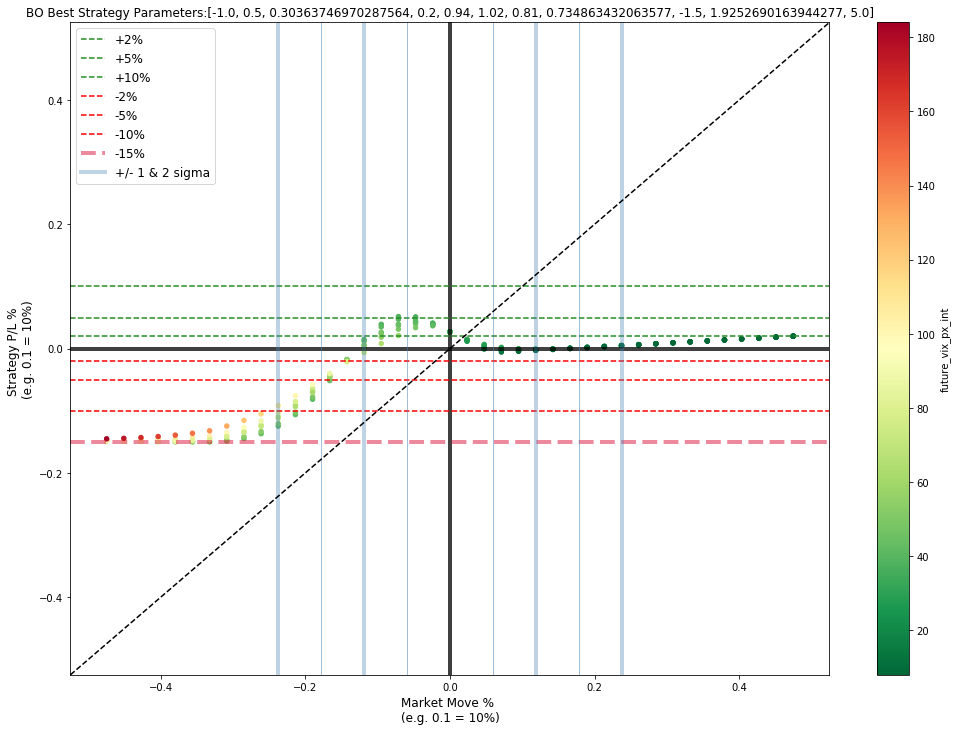

In [1783]:
temp_opt_res, strat_params = run_bo_result(bo_strat)

print(strat_params)

plot_opt_subplot(opt_result=temp_opt_res, ax_subplot=None, title_subplot='BO Best Strategy Parameters:'+str(strat_params), simple_plot=True)

## View some summary stats on the best optimization run and compute a form of Expected Value 

In [1784]:
perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=True)
print('EV sum:', perf_sig['EV_rough'].sum())

perf_sig.sort_values('interval_start')

Normalizing returns to a max drawdown of 15%

Max DD:  -0.2197170643695365
EV sum: 0.024247129509759446


,ann_return,interval,interval_start,interval_end,prob,EV_rough
-6.0_-2.0_sigma,-0.85325,"(-0.7415722889255361, -0.23730313245617154)",-0.741572,-0.237303,0.0225,-0.0191981
-2.0_-1.5_sigma,-0.54457,"(-0.23730313245617154, -0.17797734934212867)",-0.237303,-0.177977,0.0445,-0.0242334
-1.5_-1.0_sigma,-0.193037,"(-0.17797734934212867, -0.11865156622808577)",-0.177977,-0.118652,0.091,-0.0175663
-1.0_-0.5_sigma,0.137368,"(-0.11865156622808577, -0.059325783114042886)",-0.118652,-0.0593258,0.15,0.0206051
-0.5_-0.0_sigma,0.247718,"(-0.059325783114042886, 0.0)",-0.0593258,0,0.1915,0.0474379
0.0_0.5_sigma,0.0891112,"(0.0, 0.059325783114042886)",0,0.0593258,0.1915,0.0170648
0.5_1.0_sigma,-0.0119047,"(0.059325783114042886, 0.11865156622808577)",0.0593258,0.118652,0.15,-0.00178571
1.0_1.5_sigma,-0.00510236,"(0.11865156622808577, 0.17797734934212867)",0.118652,0.177977,0.091,-0.000464314
1.5_2.0_sigma,0.0158323,"(0.17797734934212867, 0.23730313245617154)",0.177977,0.237303,0.0445,0.000704535
2.0_6.0_sigma,0.074782,"(0.23730313245617154, 0.7415722889255361)",0.237303,0.741572,0.0225,0.0016826


In [1785]:
def get_top_opt_results(opt_result, top_n=10):
    
    val_list = opt_result.res['all']['values']
    top_idx = sorted(range(len(val_list)), key=lambda i: val_list[i], reverse=True)[:top_n]
    
    return top_idx


def plot_bo_results( bo_strat, strat_params_explore, max_explore_plots=3, subplots_total=16, subplot_cols=2, figsize=(30, 80), plot_hspace=0.35):
    
    matplotlib.rcParams['figure.figsize'] = figsize

    subplot_rows = int( subplots_total / subplot_cols)
    subplot_coord = [(row, col) for row in range(subplot_rows) for col in range(subplot_cols)]

    f, axarr = plt.subplots(subplot_rows, subplot_cols)
    
    count = 0
    count_explore = 0
    count_best_bo = 0

    num_explore_combos = None
    if max_explore_plots is None:
        num_explore_combos = len( strat_params_explore[ list(strat_params_explore.keys())[0] ] )
    else:
        num_explore_combos = max_explore_plots

    top_opt_results_idx = get_top_opt_results(bo_strat, top_n=subplots_total)

    for ax_coord in subplot_coord:
        ax_plot_done = False

        if count == 0: 
            temp_opt_res, strat_params = run_bo_result(bo_strat)
            plot_opt_subplot( opt_result=temp_opt_res, ax_subplot=axarr[ ax_coord[0], ax_coord[1] ], title_subplot='(' + str(count) + ')  ' + 'Best Optimization Result \n' + str(np.round(strat_params,2)) + '\n Obj Func Val=' + str(np.round(bo_strat.res['max']['max_val'],4)) )
            ax_plot_done = True

        if not ax_plot_done:
            if count_explore < num_explore_combos:
                temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='init_trial', trial_num=count_explore )
                plot_opt_subplot( opt_result=temp_opt_res, ax_subplot=axarr[ ax_coord[0], ax_coord[1] ], title_subplot='(' + str(count) + ')  ' + 'Explore Result: ' + str(count_explore+1) + '\n' + str(np.round(strat_params,2)) )
                count_explore = count_explore + 1
                ax_plot_done = True

        if not ax_plot_done:
            temp_opt_res, strat_params = run_bo_result(bo_strat, run_type='bo_trial', trial_num=top_opt_results_idx[count_best_bo] )
            temp_obj_val = bo_strat.res['all']['values'][ top_opt_results_idx[count_best_bo] ]
            plot_opt_subplot( opt_result=temp_opt_res, ax_subplot=axarr[ ax_coord[0], ax_coord[1] ], title_subplot='(' + str(count) + ')  ' + 'BO Result: ' + str(count_best_bo+1) + '\n' + str(np.round(strat_params,2)) + '\n Obj Func Val=' + str(np.round(temp_obj_val,4)) )
            count_best_bo = count_best_bo + 1
            ax_plot_done = True


        count = count + 1

    print('Bayesian Optimization Results. Following top results are based on your objective function specified Market Move range. \n All returns plotted are normalized to a max drawdown of 15%.')

    plt.subplots_adjust(hspace=plot_hspace)

# Plot the Top N strategies discovered from the Bayesian Optimization

Bayesian Optimization Results. Following top results are based on your objective function specified Market Move range. 
 All returns plotted are normalized to a max drawdown of 15%.


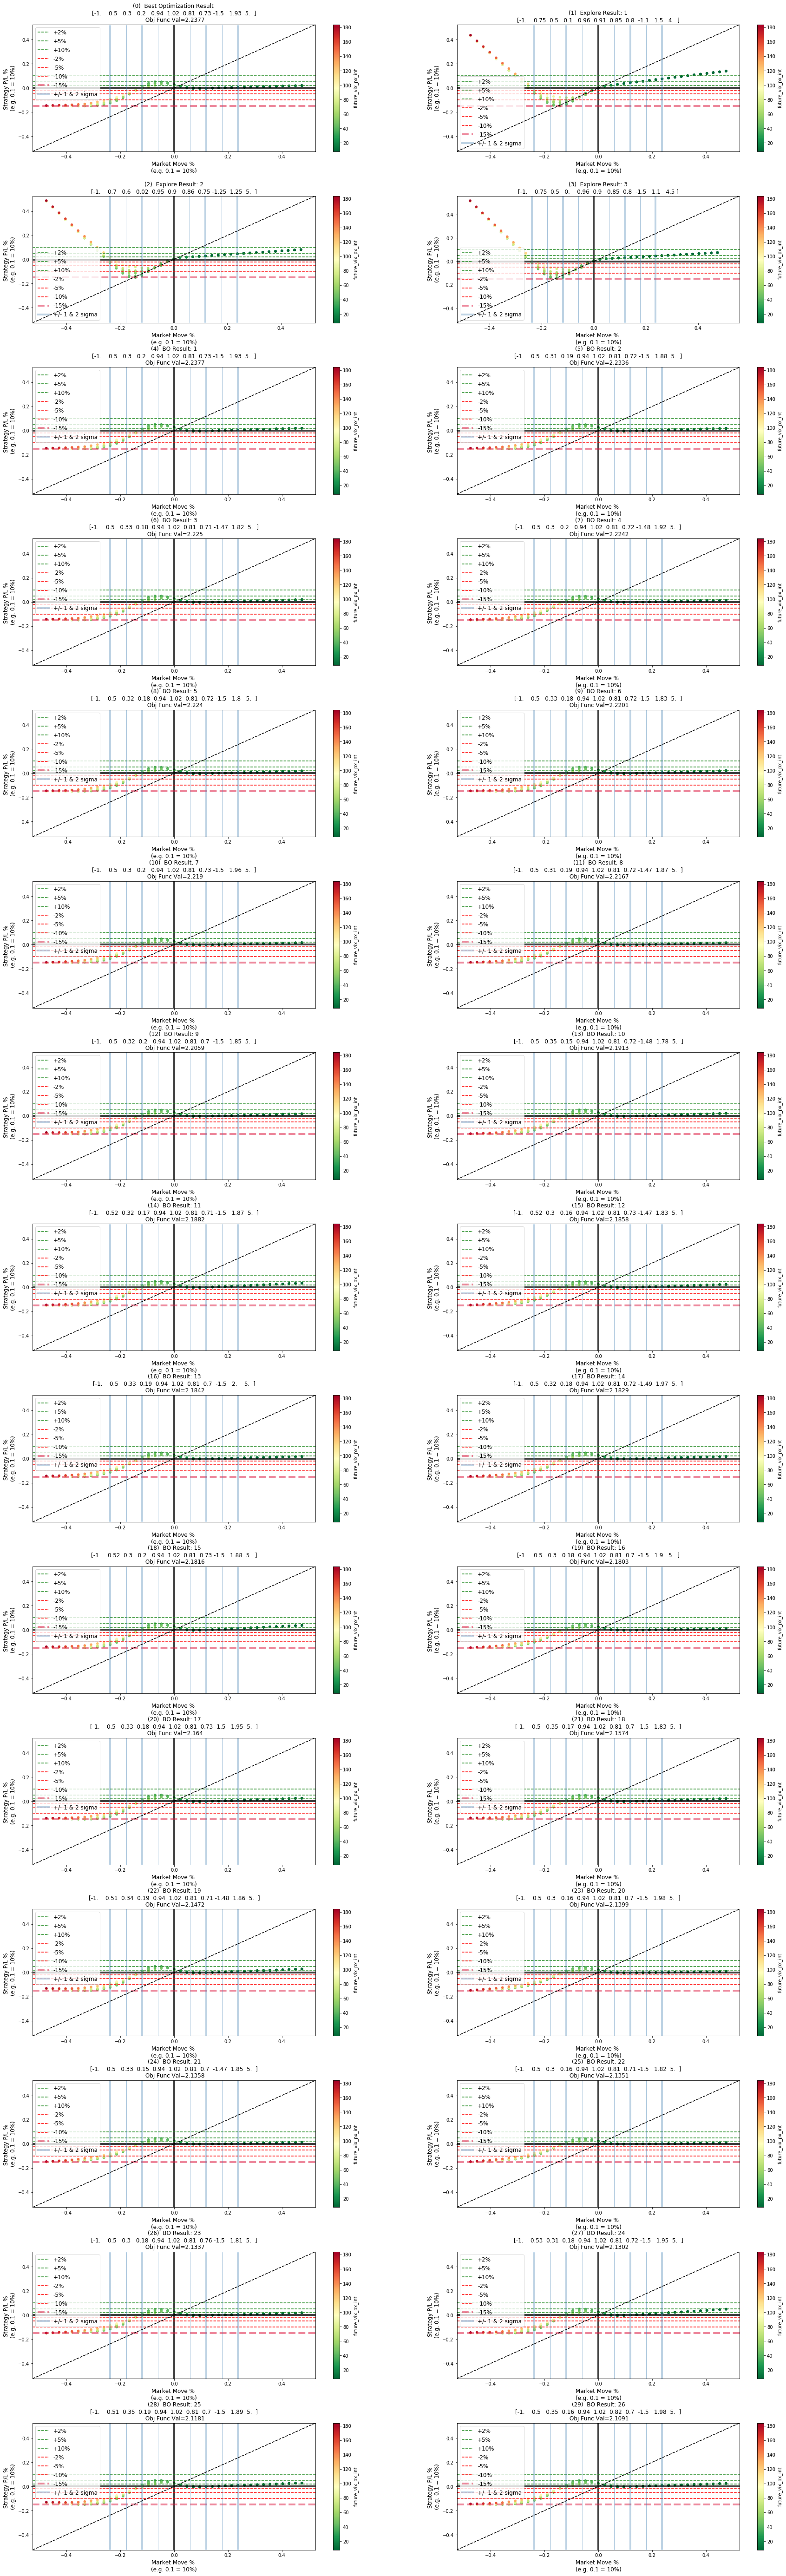

In [1786]:
plot_bo_results(bo_strat=bo_strat, strat_params_explore=strat_params_explore_stage_1, 
                subplots_total=30, figsize=(30,100), plot_hspace=0.35)

In [1787]:
print('Stage 1 - DONE.')

Stage 1 - DONE.


In [1791]:
top_opt_pct_to_target = 0.10
top_opt_specific_runs = []



top_opt_params = {}

bo_num_trials = len( bo_strat.res['all']['params'] )

for param_name in bo_strat.res['all']['params'][0]:
    top_opt_params[param_name] = []

    top_opt_params
#for param_name in bo_strat.res['all']['params'][0]:
for param_name in top_opt_params:
    for top_idx in get_top_opt_results(bo_strat, top_n=int(bo_num_trials * top_opt_pct_to_target)):
        top_opt_params[param_name].append( bo_strat.res['all']['params'][top_idx][param_name] )
        
top_opt_params_range = {}  
range_pad_pct = .1
for param_name in top_opt_params:
    range_min = np.min(top_opt_params[param_name])
    range_max = np.max(top_opt_params[param_name])
    
    range_diff = range_max - range_min
    range_pad_amt = range_diff * range_pad_pct
    
    top_opt_params_range[ param_name ] = ( max(range_min - range_pad_amt, strat_params_stage_1[param_name][0]) , min(range_max + range_pad_amt, strat_params_stage_1[param_name][1]) )
         

In [1792]:
top_opt_params_range

{'short_p_1_n': (-1.0, -1.0),
 'long_p_1_n': (0.5, 0.5003200753448864),
 'long_p_2_n': (0.3, 0.335616944004041),
 'long_p_3_n': (0.1735703712824906, 0.2),
 'short_p_1_m': (0.94, 0.94),
 'long_p_1_m': (1.02, 1.02),
 'long_p_2_m': (0.81, 0.8127337624227687),
 'long_p_3_m': (0.7081037916556603, 0.7372961266461149),
 'short_u_hr': (-1.5, -1.4635000375183789),
 'long_c_1_hf': (1.7877374093652256, 1.9377718897607188),
 'exp_factor': (5.0, 5.0)}

# Run Stage 2 of the Bayesian Optimization - Exploring and Exploiting around the parameter space discovered in Stage 1

In [1793]:
####### STAGE 2 BO ####
try:
    del bo_strat_stage_2
except:
    pass

#bo_strat_stage_2 = BayesianOptimization(strat_obj_func_maximize_wrapper_FLAT, top_opt_params_range)
bo_strat_stage_2 = BayesianOptimization(strat_obj_func_maximize_wrapper_CUSTOM, top_opt_params_range)

strat_params_explore_stage_2 = top_opt_params
bo_strat_stage_2.explore( strat_params_explore_stage_2 )

#bo_strat_stage_2.maximize(init_points=20, n_iter=200, acq="ei", xi=0.033)   # 0.0=exploit,  0.1=explore

#bo_strat_stage_2.maximize(init_points=20, n_iter=150, acq="ei", xi=0.01)   # 0.0=exploit,  0.1=explore
bo_strat_stage_2.maximize(init_points=20, n_iter=60, acq="ei", xi=0.03)   # 0.0=exploit,  0.1=explore

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   exp_factor |   long_c_1_hf |   long_p_1_m |   long_p_1_n |   long_p_2_m |   long_p_2_n |   long_p_3_m |   long_p_3_n |   short_p_1_m |   short_p_1_n |   short_u_hr | 
    1 | 00m01s |    2.23773 |       5.0000 |        1.9253 |       1.0200 |       0.5000 |       0.8100 |       0.3036 |       0.7349 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
    2 | 00m01s |    2.23358 |       5.0000 |        1.8774 |       1.0200 |       0.5000 |       0.8125 |       0.3143 |       0.7203 |       0.1886 |        0.9400 |       -1.0000 |      -1.5000 | 
    3 | 00m01s |    2.22503 |       5.0000 |        1.8177 |       1.0200 |       0.5003 |       0.8100 |       0.3324 |       0.7105 |       0.1760 |        0.9400 |       -1.0000 |      -1

/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.26776694e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


   34 | 00m29s |    2.20268 |       5.0000 |        1.9378 |       1.0200 |       0.5000 |       0.8127 |       0.3152 |       0.7373 |       0.2000 |        0.9400 |       -1.0000 |      -1.4635 | 
   35 | 00m29s |    2.20884 |       5.0000 |        1.7877 |       1.0200 |       0.5003 |       0.8100 |       0.3205 |       0.7248 |       0.2000 |        0.9400 |       -1.0000 |      -1.4635 | 
   36 | 00m30s |    2.20069 |       5.0000 |        1.9378 |       1.0200 |       0.5000 |       0.8127 |       0.3168 |       0.7321 |       0.1736 |        0.9400 |       -1.0000 |      -1.5000 | 
   37 | 00m35s |    2.22835 |       5.0000 |        1.9378 |       1.0200 |       0.5003 |       0.8127 |       0.3000 |       0.7081 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   38 | 00m34s |    2.24237 |       5.0000 |        1.8572 |       1.0200 |       0.5003 |       0.8127 |       0.3285 |       0.7224 |       0.1736 |        0.9400 |       -1.0000 |      -1.4635 | 
   39

/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.90046707e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


   44 | 00m20s |    2.11455 |       5.0000 |        1.9378 |       1.0200 |       0.5003 |       0.8100 |       0.3297 |       0.7373 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   45 | 00m22s |    2.23033 |       5.0000 |        1.8966 |       1.0200 |       0.5003 |       0.8127 |       0.3027 |       0.7373 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   46 | 00m26s |    2.21473 |       5.0000 |        1.7877 |       1.0200 |       0.5003 |       0.8100 |       0.3356 |       0.7081 |       0.1736 |        0.9400 |       -1.0000 |      -1.5000 | 
   47 | 00m25s |    2.17606 |       5.0000 |        1.9378 |       1.0200 |       0.5003 |       0.8100 |       0.3356 |       0.7081 |       0.2000 |        0.9400 |       -1.0000 |      -1.4635 | 
   48 | 00m18s |    2.23242 |       5.0000 |        1.7877 |       1.0200 |       0.5003 |       0.8100 |       0.3280 |       0.7208 |       0.1736 |        0.9400 |       -1.0000 |      -1.4779 | 
   49

/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.83490573e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


   53 | 00m08s |    2.21082 |       5.0000 |        1.7877 |       1.0200 |       0.5000 |       0.8127 |       0.3184 |       0.7250 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   54 | 00m12s |    2.24689 |       5.0000 |        1.7877 |       1.0200 |       0.5000 |       0.8127 |       0.3000 |       0.7101 |       0.2000 |        0.9400 |       -1.0000 |      -1.4635 | 
   55 | 00m09s |    2.27185 |       5.0000 |        1.7877 |       1.0200 |       0.5000 |       0.8127 |       0.3000 |       0.7373 |       0.2000 |        0.9400 |       -1.0000 |      -1.4635 | 
   56 | 00m06s |    2.20847 |       5.0000 |        1.9090 |       1.0200 |       0.5000 |       0.8127 |       0.3158 |       0.7081 |       0.2000 |        0.9400 |       -1.0000 |      -1.4635 | 
   57 | 00m04s |    2.14188 |       5.0000 |        1.9378 |       1.0200 |       0.5003 |       0.8100 |       0.3000 |       0.7373 |       0.1786 |        0.9400 |       -1.0000 |      -1.4833 | 
   58

/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.53754367e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


   60 | 00m04s |    2.14043 |       5.0000 |        1.7877 |       1.0200 |       0.5003 |       0.8127 |       0.3000 |       0.7373 |       0.1736 |        0.9400 |       -1.0000 |      -1.4635 | 
   61 | 00m04s |    2.21112 |       5.0000 |        1.9378 |       1.0200 |       0.5000 |       0.8100 |       0.3356 |       0.7373 |       0.1736 |        0.9400 |       -1.0000 |      -1.4635 | 
   62 | 00m03s |    2.21473 |       5.0000 |        1.9378 |       1.0200 |       0.5000 |       0.8100 |       0.3356 |       0.7081 |       0.1736 |        0.9400 |       -1.0000 |      -1.5000 | 
   63 | 00m03s |    2.22254 |       5.0000 |        1.8625 |       1.0200 |       0.5000 |       0.8100 |       0.3121 |       0.7158 |       0.1883 |        0.9400 |       -1.0000 |      -1.4635 | 
   64 | 00m03s |    2.18441 |       5.0000 |        1.7885 |       1.0200 |       0.5000 |       0.8104 |       0.3164 |       0.7081 |       0.1741 |        0.9400 |       -1.0000 |      -1.4639 | 
   65

/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010898]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


   74 | 00m06s |    2.20268 |       5.0000 |        1.8982 |       1.0200 |       0.5003 |       0.8100 |       0.3187 |       0.7373 |       0.2000 |        0.9400 |       -1.0000 |      -1.4635 | 
   75 | 00m04s |    2.27185 |       5.0000 |        1.8451 |       1.0200 |       0.5003 |       0.8127 |       0.3000 |       0.7373 |       0.2000 |        0.9400 |       -1.0000 |      -1.4635 | 


/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00014081]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


   76 | 00m04s |    2.23598 |       5.0000 |        1.8977 |       1.0200 |       0.5003 |       0.8100 |       0.3356 |       0.7197 |       0.1736 |        0.9400 |       -1.0000 |      -1.4635 | 
   77 | 00m04s |    2.24650 |       5.0000 |        1.9378 |       1.0200 |       0.5003 |       0.8127 |       0.3000 |       0.7373 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   78 | 00m04s |    2.21902 |       5.0000 |        1.9378 |       1.0200 |       0.5003 |       0.8100 |       0.3000 |       0.7237 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   79 | 00m04s |    2.12101 |       5.0000 |        1.8246 |       1.0200 |       0.5003 |       0.8127 |       0.3000 |       0.7373 |       0.1736 |        0.9400 |       -1.0000 |      -1.5000 | 
   80 | 00m04s |    2.20216 |       5.0000 |        1.9378 |       1.0200 |       0.5000 |       0.8127 |       0.3209 |       0.7081 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   81

/Users/justinlent/anaconda_2019_10/anaconda3/envs/quant_robinhood_bayes_0_1_0/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00026613]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


   82 | 00m03s |    2.20355 |       5.0000 |        1.8572 |       1.0200 |       0.5000 |       0.8127 |       0.3111 |       0.7373 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   83 | 00m03s |    2.22056 |       5.0000 |        1.8516 |       1.0200 |       0.5003 |       0.8100 |       0.3356 |       0.7126 |       0.1736 |        0.9400 |       -1.0000 |      -1.4910 | 
   84 | 00m03s |    2.15236 |       5.0000 |        1.8173 |       1.0200 |       0.5003 |       0.8100 |       0.3356 |       0.7081 |       0.2000 |        0.9400 |       -1.0000 |      -1.5000 | 
   85 | 00m03s |    2.22530 |       5.0000 |        1.9378 |       1.0200 |       0.5003 |       0.8127 |       0.3195 |       0.7199 |       0.1898 |        0.9400 |       -1.0000 |      -1.4635 | 
   86 | 00m04s |    2.16380 |       5.0000 |        1.8605 |       1.0200 |       0.5003 |       0.8100 |       0.3126 |       0.7081 |       0.1736 |        0.9400 |       -1.0000 |      -1.5000 | 


## Plot the Top N results from Stage 2 of the optimization

Bayesian Optimization Results. Following top results are based on your objective function specified Market Move range. 
 All returns plotted are normalized to a max drawdown of 15%.


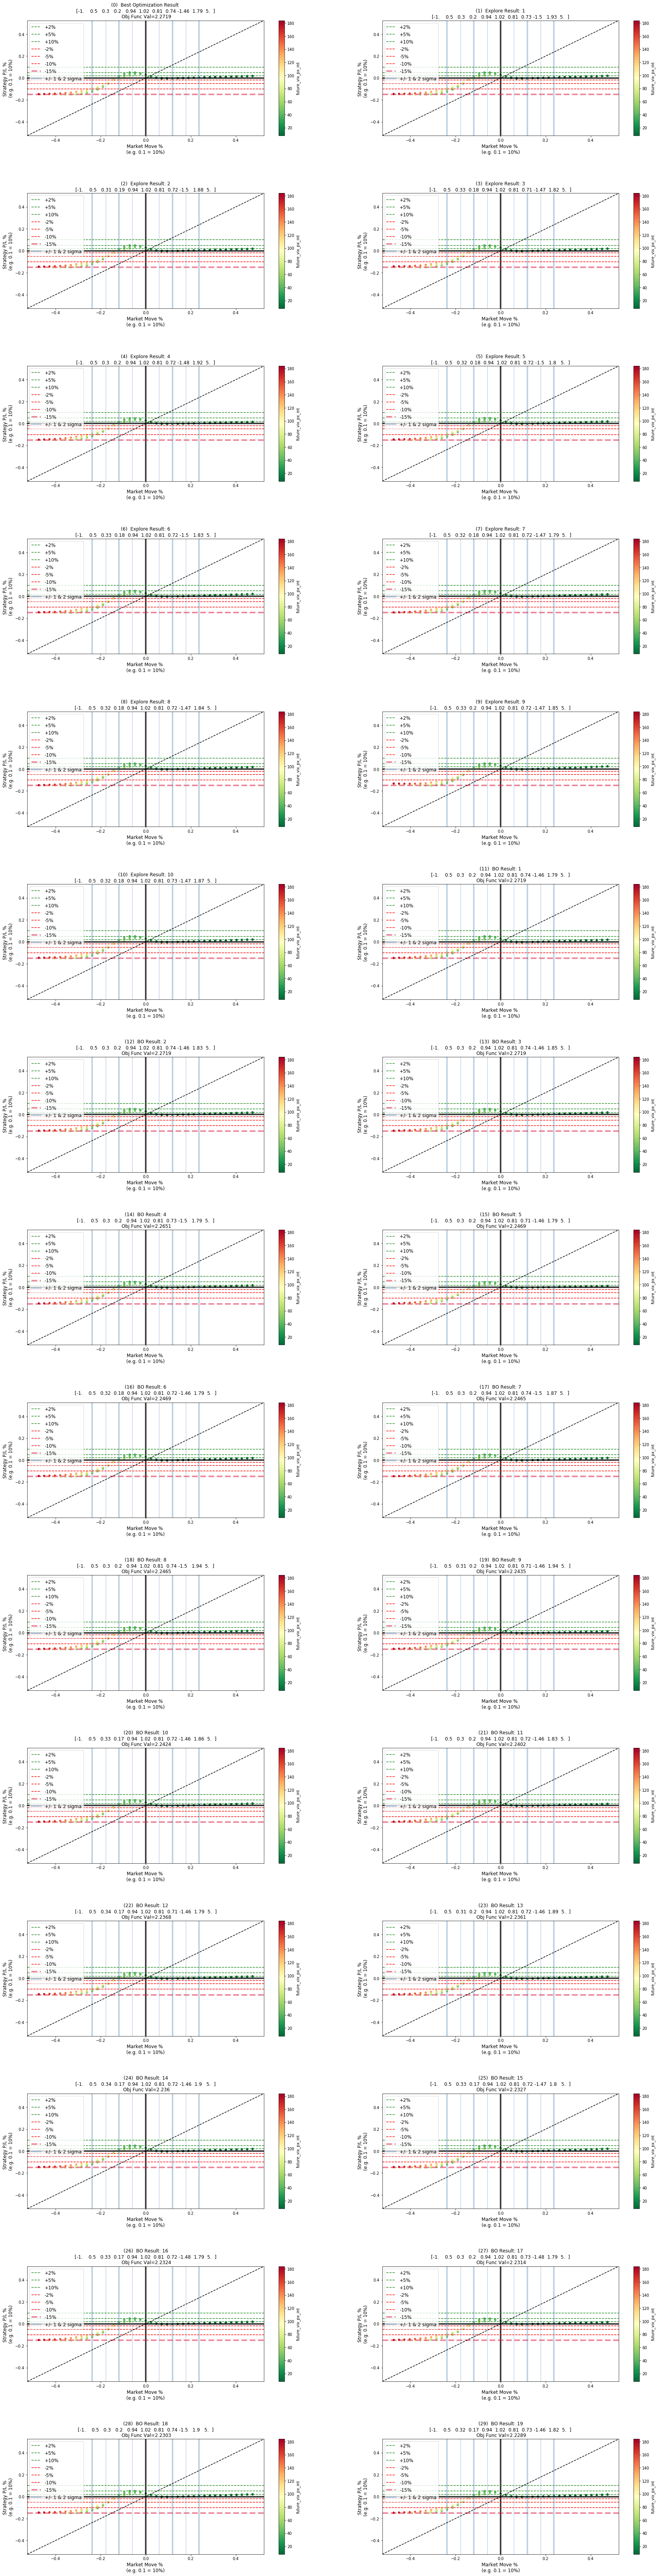

In [1795]:
bo_results_viz_setup = {}
bo_results_viz_setup['explore_num'] = 10
bo_results_viz_setup['total_results'] = 60 

plot_bo_results(bo_strat=bo_strat_stage_2, strat_params_explore=strat_params_explore_stage_2, 
                max_explore_plots=bo_results_viz_setup['explore_num'], 
                subplots_total=30,
                figsize=(30,120), plot_hspace=0.50)

### Now compare the Stage 1 best result to the Stage 2 best result

In [1798]:
# Display the perf stats associated from ** STAGE 1 ** of the optimization

temp_opt_res, strat_params = run_bo_result(bo_strat)

perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=True)
print('EV sum:', perf_sig['EV_rough'].sum())

perf_sig.sort_values('interval_start')

Normalizing returns to a max drawdown of 15%

Max DD:  -0.2197170643695365
EV sum: 0.024247129509759446


,ann_return,interval,interval_start,interval_end,prob,EV_rough
-6.0_-2.0_sigma,-0.85325,"(-0.7415722889255361, -0.23730313245617154)",-0.741572,-0.237303,0.0225,-0.0191981
-2.0_-1.5_sigma,-0.54457,"(-0.23730313245617154, -0.17797734934212867)",-0.237303,-0.177977,0.0445,-0.0242334
-1.5_-1.0_sigma,-0.193037,"(-0.17797734934212867, -0.11865156622808577)",-0.177977,-0.118652,0.091,-0.0175663
-1.0_-0.5_sigma,0.137368,"(-0.11865156622808577, -0.059325783114042886)",-0.118652,-0.0593258,0.15,0.0206051
-0.5_-0.0_sigma,0.247718,"(-0.059325783114042886, 0.0)",-0.0593258,0,0.1915,0.0474379
0.0_0.5_sigma,0.0891112,"(0.0, 0.059325783114042886)",0,0.0593258,0.1915,0.0170648
0.5_1.0_sigma,-0.0119047,"(0.059325783114042886, 0.11865156622808577)",0.0593258,0.118652,0.15,-0.00178571
1.0_1.5_sigma,-0.00510236,"(0.11865156622808577, 0.17797734934212867)",0.118652,0.177977,0.091,-0.000464314
1.5_2.0_sigma,0.0158323,"(0.17797734934212867, 0.23730313245617154)",0.177977,0.237303,0.0445,0.000704535
2.0_6.0_sigma,0.074782,"(0.23730313245617154, 0.7415722889255361)",0.237303,0.741572,0.0225,0.0016826


In [1799]:
# Display the perf stats associated from ** STAGE 2 ** of the optimization

temp_opt_res, strat_params = run_bo_result(bo_strat_stage_2)

perf_sig = perf_by_sigma_bands(temp_opt_res, mkt_implied_1sigma_move, calendar_days_ahead_to_reprice, use_norm_returns=True)
print('EV sum:', perf_sig['EV_rough'].sum())

perf_sig.sort_values('interval_start')

Normalizing returns to a max drawdown of 15%

Max DD:  -0.21997851472674465
EV sum: 0.02437922025349346


,ann_return,interval,interval_start,interval_end,prob,EV_rough
-6.0_-2.0_sigma,-0.855348,"(-0.7415722889255361, -0.23730313245617154)",-0.741572,-0.237303,0.0225,-0.0192453
-2.0_-1.5_sigma,-0.541424,"(-0.23730313245617154, -0.17797734934212867)",-0.237303,-0.177977,0.0445,-0.0240934
-1.5_-1.0_sigma,-0.190566,"(-0.17797734934212867, -0.11865156622808577)",-0.177977,-0.118652,0.091,-0.0173415
-1.0_-0.5_sigma,0.139053,"(-0.11865156622808577, -0.059325783114042886)",-0.118652,-0.0593258,0.15,0.0208579
-0.5_-0.0_sigma,0.248474,"(-0.059325783114042886, 0.0)",-0.0593258,0,0.1915,0.0475828
0.0_0.5_sigma,0.0890701,"(0.0, 0.059325783114042886)",0,0.0593258,0.1915,0.0170569
0.5_1.0_sigma,-0.0128307,"(0.059325783114042886, 0.11865156622808577)",0.0593258,0.118652,0.15,-0.0019246
1.0_1.5_sigma,-0.00704401,"(0.11865156622808577, 0.17797734934212867)",0.118652,0.177977,0.091,-0.000641005
1.5_2.0_sigma,0.012858,"(0.17797734934212867, 0.23730313245617154)",0.177977,0.237303,0.0445,0.000572181
2.0_6.0_sigma,0.0691175,"(0.23730313245617154, 0.7415722889255361)",0.237303,0.741572,0.0225,0.00155514


## Print out the actual trades you should make in the market to implement the strategy

In [1806]:
print('\nPorfolio $:  $', portfolio_notional)

total_cash_flow = 0

for i in trade_info_dict['portfolio']:
    p = trade_info_dict['portfolio']
    #print(p)
    #print(p[i])
    temp_px = np.round(trade_info_dict['initial_prices'][ i ],2)
    temp_leg_delta = trade_info_dict['greeks']['individual_port_greeks'][i]['delta']
    
    print( i, str(p[i].num_contracts)
          , str(p[i].strike)
          , str(p[i].initial_imp_vol)
          , str(p[i].exp_date)
          , str( temp_px )
          , str(p[i].num_contracts * temp_px * 100.) 
          , str( p[i].num_contracts * temp_leg_delta * p[i].initial_imp_vol )
         )
    total_cash_flow = total_cash_flow + (p[i].num_contracts * temp_px * 100.)
    
print("\nUnderlying shares to trade: "
      , np.round(trade_info_dict['greeks']['portfolio_level_greeks']['delta_underlying'], 2)
      , np.round(trade_info_dict['greeks']['portfolio_level_greeks']['delta_underlying'] * market_current, 2)
      , trade_info_dict['greeks']['individual_port_greeks'][i]['delta']
     )
print("Total Cash Flow: ", str(total_cash_flow))


Porfolio $:  $ 1000000
short_put_1 -117 272 0.366809 2020-06-19 00:00:00 8.22 -96174.00000000001 13.095653323858274
long_put_1 58 295 0.294231 2020-06-19 00:00:00 16.01 92858.0 -9.48559537927848
long_put_2 35 235 0.467161 2020-06-19 00:00:00 2.56 8960.0 -1.6416246389172944
long_put_3 23 214 0.520711 2020-06-19 00:00:00 1.23 2829.0 -0.5895697907717722
long_call_1 2 246 0.439753 2020-06-19 00:00:00 3.7 740.0 -0.12568102306827156

Underlying shares to trade:  173.18 50152.81 -0.1428995630140915
Total Cash Flow:  9212.999999999985


[-1.0, 0.5, 0.3, 0.2, 0.94, 1.02, 0.8127337624227687, 0.7372961266461149, -1.4635000375183789, 1.7877374093652256, 3.409423874561765]


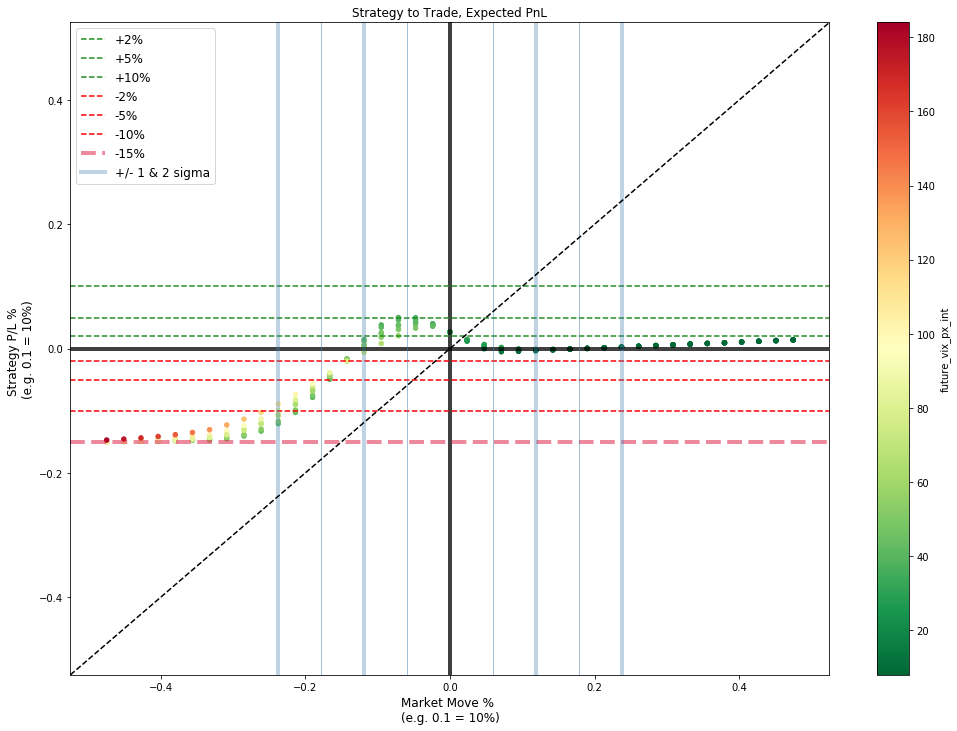

In [1807]:
strat_inputs = list( trade_info_dict['strat_params'].values() ) 
print(strat_inputs)

temp_opt_res = single_opt_run( opt_run_inputs=strat_inputs )
#temp_opt_res = single_opt_run( opt_run_inputs=list( temp_strat_p_1.values() ) )

plot_opt_subplot(opt_result=temp_opt_res, ax_subplot=None, title_subplot='Strategy to Trade, Expected PnL'
                 , simple_plot=True
                 , use_norm_returns=True)

# Done!